# Week 2

The most accessible way to measure brain activity is using electrodes placed on the scalp, referred to as electroencephalography (EEG). These are weak signals, on the order of X uV, which is ~100,000 times weaker than the voltage of a AAA battery. To measure these we use specialized electrodes and amplifiers. Since this course is focused on the signal and data analysis end of BCI, we will not 

In [1]:
import os.path as op
import math
import pandas as pd
import numpy as np
import scipy.io as sio
import scipy.signal as ss
import scipy.stats as st
import matplotlib.pyplot as plt

## Acquisition of EEG
EEG was one of the first widely accesible ways to track the activity of awake behaving subjects. It was developed in the 1920s by Hans Berger. He found that by inserting metal electrodes into the scalp, he was able to detect extremely weak electrical signals. While initially dismissed by the scientific community, he work was subsequently validated by the prominent neurophysiologist E.D. Adrien. Given the ease of obtaining the EEG signal, and that it did not require opening up the skull, it rapidly became a widespread tool for the study of brain activity. Today, it is commonly used in medicine to help diagnose medical conditions, such as epilepsy, characterize sleep distrubances using polysomnography, and in research labs to further our understanding of brain function. It is also a technique for studying brain activity that is readily accessible to the amature, with many companies selling do-it-yourself EEG recording kits (e.g. X). For a thorough manual on acquiring and interpreting EEG signals check out https://academic.oup.com/book/35515.

### EEG signal
As we reviewed in Week 1, the transmembrane currents of neurons produce voltages that can be picked up by electrodes. As those electrodes are moved farther away from the neurons, this voltage falls off. When ones electrode reaches the surface of the scalp, the voltages from individual neurons are so weak that they cannot be distinguished from each other. Instead, it is the shared transmembrane currents across all the neurons within several centimeters of the electrode that make up the EEG signal. We saw that the very large currents contributed to the action potentials of single neurons were not visible once we were 2 cm from the neurons, but the shared slow fluctuations and synaptic currents were evident. It is estimated that the total area of cortex required to be coactivated sufficiently to generate a detectable scalp potential is around 6 cm<sup>2</sup> (Ebersole 1997). Consequently, the EEG reflects widespread activations.

Our simplified model ignored a few details that apply to real brains and that influence the EEG. First, neurons are not 'point-sources', i.e. they are not a single current source but have dendrites that currents also flow through. This create a dipole that influenes the distribution of transmembrane currents and the voltages recorded at the scalp. Second, the cortical surface has a convoluted surface, with neurons oriented at different angles with respect to the scalp. This angling affects both the magnitude and the sign of voltage picked up on the scalp, making it exceptionally difficult to reconstruct exactly what neural sources generated any recorded potential. Lastly, we assumed that the conductivity of the tissue between the neuron and the scalp electrode was Ohmic (homogenous), but this is not the case. A neural potential passes through brain tissue, the cerebrospinal fluid, dura mater that encapsulates the brain, bone of the skull, and the skin. These tissues have different conductivities, further complicating the reconstruction of the underlying neural generators.

### Electrode placement
The electrodes used in EEG research are small metal discs that are pressed into a conductive gel resting on the scalp. This gel allows electrical activity on the scalp to easily conduct to the electrode. Often the skin under the gel has to be abrated a bit to remove the top layer of dead skin cells and oil that have low conductivity.

[DIAGRAM OF EEG ELECTRODE]

While it is not possible to exactly reconstruct the EEG sources, by placing multiple electrodes across the scalp one can observe some coarse localization of brain activity (see https://robertoostenveld.nl/electrode/#jasper1958 for a nice discussion). For instance, presenting an auditory stimulus elicits a potential over the portion of the scalp overlying the temporal lobe, where auditory cortex is, while visual stimuli elicit potentials over occipital cortex, where visual cortex is [CITATIONS]. So, there seems to be some loose relationship between a signal in the EEG and the source of that signal. This highlights the need to place multiple electrodes over the scalp to get a complete picture of the brain activity. 

In 1958 a standard was adopted for placement and naming of EEG electrodes with respect to features on the skull. It has been updated periodically over the decades (https://journals.lww.com/clinicalneurophys/Citation/1994/01000/Guideline_Thirteen__Guidelines_for_Standard.14.aspx), with the most recent incarnation known as the 10-20 system. The 10 refers to the percent distance between adjacent electrodes along the front-back axis of the skull (also referred to as rostro-caudal or anterior-posterior). 20 refers to the percent distance between adjacent electrodes along the left-right axis of the skull (also referred to as medial-lateral). Electrodes are named with a combination of letters and numbers. Each starts with letters corresponding to the region of the brain they lie immediately over:
|Letters|Region|
|-----|----|
|Fp| Prefrontal|
|F| Frontal|
|C| Central|
|T| Temporal|
|P| Parietal|
|O| Occipital|

Each is followed by a number or the letter 'z'. 'z' is used for sites along the midline, even numbers on the right hemisphere, and odd numbers on the left hemisphere. The numbers start at 1 and increase as electrode sites are moved away from the midline, i.e. laterally. This layout looks like:
[IMAGE OF 10-20 SYSTEM]

Recently, the number of recording sites has increased because of advances the miniaturization of recording systems. The recordings we will draw from for these lectures use the 10-20 extended system, that features more recording sites. In addition to the names used above, also included are sites that are equally close to two areas and will have their letters joined, e.g. FC (frontal-central) and PO (parietal-occipital). Its layout is:
[IMAGE OF EXTENDED 10-20 SYSTEM]

In addition to electrodes that are explicitly targeted to record brain activity, additional electrodes are used for referencing and detection of contaminating noise and artifacts.

### Referencing
Since voltage is a measure of the work needed to move a charge from one place to another, it is always measured between two points. The point whose signal we seek to measure is referred to as the *active* site. It is measured with respect to another point, the *ground*. Ideally, the ground would be at a point in space that is infinitely far away from the electrode and with no charges near it to contaminate the potential we are attempting to measure at the EEG site. This is not practical (nor would it work due to limitations in electronic hardware). Instead, researchers often place the ground immediately behind the ear (referred to as the mastoid). If we only measured our signal at the active site then we face a new problem: there are numerous sources of environmental electrical noise that envelope the entire head, such as emissions from the AC power in the walls. To eliminate that, one also records from a *reference* electrode, whose signal is subtracted from the active. Any signal that is shared between the active and reference sites is removed (which includes signal at the ground site, since both the active and reference are measured relative to the same ground electrode). The degree of removal is referred to as the *common-mode rejection ratio* and depends on the quality of the amplifiers and conductivity between the electrodes and scalp. A good common-mode rejection ratio is 70 decibels (dB), which means that the shared signal is reduced by a factor of 10,000,000 ($dB = 10log_{10}(x)$)!

[INSERT FIGURE OF ACTIVE VS GROUND VS REFERENCE SITES]

### Loading and inspecting the EEG

What does the EEG signal look like? Let's load and visualize some EEG data.

The datasets we will work with are structured in a standardized way, which shoul make it easy to adapt our code between them. This data is coming from the [openneuro.org](https://openneuro.org), a public repository of neural activity recordings from humans across a range of measures (e.g. EEG, MEG, fMRI). We will focus on EEG datasets. The ones that are ideal for our use are:

LIST OF EEG STUDIES THAT CAN BE USED BY STUDENTS

Each of these is organized as a collection of nested directories. In the top most directory we have a README file that gives details about how the EEG was recorded and the tasks that subjects performed during the recording. 

Each subject will have their own subdirectory, which contains directories for different aspects of the experiment. There should be one labeled 'eeg', where the eeg data is. Sometimes you also see a 'beh' folder, which has the behavior of the subject. Within the eeg folder we will focus on the \*.set files. These are produced the the EEGLAB toolbox in MATLAB and contain both the EEG data and additional data about electrode names, referencing, etc.

To load the set file, we use the loadmat method in the Scipy IO package.

In [2]:
# load the a .set file
subj = 'sub-AB58'
data_dir = ['data', 'ds003690', subj, 'eeg', '{}_task-passive_run-1_eeg.set'.format(subj)]
eeg_file = op.join(*data_dir) # use * to unpack the list
eeg = sio.loadmat(eeg_file)

A few notes about the file paths and names. In the directory where we have our analysis code (which is this Jupyter notebook), we include a 'data' directory that contains folders to the datasets we want to work with. This allows us to use a *relative file path*, where we don't have to specify the entire list of directories that lead up the the one we are presently in (known as the *absolute file path*). This improves portability of the code, because someone else could put this on their computer and not have to change the file path. Another thing we do is specify the directories as a series of strings, and use the python function `join` in the os package to paste these together into a file name. This is because depending on whether you are running the code on a Windows, Mac, or Linux computer, the directory separator will be different ('\' for windows, '/' for Max and Linux).

Another thing to notice is that the file names are descriptive. For the .set file above, the subject name (sub-AB58), task (task-passive), and experimental run (run-1), and data type (eeg) are given. These are separated by underscores. This standard formulation makes it easier to us to quickly look at the files in a directory and determine which ones are relevant to us, write code that automatically accesses files from specific subjects or tasks.

Once the eeg data is loaded in, we should inspect it to determine its data type and contents.

In [3]:
# get data type
type(eeg)

dict

Just to refresh, a dictionary is a data type in python containing a collection of *keys*, where each key is associated with a *value*.

In [4]:
# get keys
eeg.keys()

dict_keys(['__header__', '__version__', '__globals__', 'setname', 'filename', 'filepath', 'subject', 'group', 'condition', 'session', 'comments', 'nbchan', 'trials', 'pnts', 'srate', 'xmin', 'xmax', 'times', 'data', 'icaact', 'icawinv', 'icasphere', 'icaweights', 'icachansind', 'chanlocs', 'urchanlocs', 'chaninfo', 'ref', 'event', 'urevent', 'eventdescription', 'epoch', 'epochdescription', 'reject', 'stats', 'specdata', 'specicaact', 'splinefile', 'icasplinefile', 'dipfit', 'history', 'saved', 'etc', 'datfile', 'run'])

If you go through the keys, some of these are self-explanetory and give information about the experiment. These are not always filled in, so don't depend on them. Instead, we will focus on:

* 'srate' - the sample rate in hz. This is how many voltage measurements were made each second per EEG site
* 'data' - the EEG data
* 'chaninfo' - the names of the eeg data channels. We can use these to determine where each EEG signal came from.
* 'ref' - where the reference channel is

Let's see what their data types are and their values.

In [5]:
def var_inspector(var):
    print('Type: {}'.format(type(var)))
    print(var)

# srate
srate = eeg['srate']
var_inspector(srate)

Type: <class 'numpy.ndarray'>
[[500]]


srate is a 2-D numpy array with a single value. To pull out just the numeric value, we have two options:

In [6]:
print(srate[0,0])
# or
print(srate[0][0])

500
500


In [7]:
srate = srate[0,0]

Next we will get the chaninfo data.

In [8]:
chan_info = eeg['chaninfo']
var_inspector(chan_info)

Type: <class 'numpy.ndarray'>
[[(array(['D:\\ProjectAgingNeuromodulation\\AuditoryResearch\\EEGLAB_analysis\\chanlocs_corrected\\AB58_locs_corrected.DAT'],
        dtype='<U106'), array(['Fp1 69 -2.854012 12.903291 -1.520481 ',
         'Fpz 69 0.583218 13.494058 -1.592608  ',
         'Fp2 69 3.935400 12.477923 -2.102277  ',
         'AF3 69 -3.023524 12.428141 1.361401  ',
         'AF4 69 4.304501 11.727693 0.427403   ',
         'F7 69 -6.639328 8.170529 -1.526560   ',
         'F5 69 -5.876012 9.542894 0.800148    ',
         'F3 69 -4.229360 10.265764 2.418731   ',
         'F1 69 -1.882614 11.018632 4.587177   ',
         'Fz 69 0.596303 10.217070 4.293318    ',
         'F2 69 3.996278 10.694478 3.944555    ',
         'F4 69 5.631967 9.848669 2.084015     ',
         'F6 69 6.969560 8.879675 -0.060155    ',
         'F8 69 7.878357 7.523402 -2.148623    ',
         'FT7 69 -7.918441 5.400486 -0.685157  ',
         'FC5 69 -6.848348 6.444450 1.872787   ',
         'FC3 69 -5.00

This is another numpy array, but it is a bit more complicated.

In [9]:
# get the channel names
chan_info = chan_info[0][0][1]
var_inspector(chan_info)


Type: <class 'numpy.ndarray'>
['Fp1 69 -2.854012 12.903291 -1.520481 '
 'Fpz 69 0.583218 13.494058 -1.592608  '
 'Fp2 69 3.935400 12.477923 -2.102277  '
 'AF3 69 -3.023524 12.428141 1.361401  '
 'AF4 69 4.304501 11.727693 0.427403   '
 'F7 69 -6.639328 8.170529 -1.526560   '
 'F5 69 -5.876012 9.542894 0.800148    '
 'F3 69 -4.229360 10.265764 2.418731   '
 'F1 69 -1.882614 11.018632 4.587177   '
 'Fz 69 0.596303 10.217070 4.293318    '
 'F2 69 3.996278 10.694478 3.944555    '
 'F4 69 5.631967 9.848669 2.084015     '
 'F6 69 6.969560 8.879675 -0.060155    '
 'F8 69 7.878357 7.523402 -2.148623    '
 'FT7 69 -7.918441 5.400486 -0.685157  '
 'FC5 69 -6.848348 6.444450 1.872787   '
 'FC3 69 -5.007377 6.820720 4.378383   '
 'FC1 69 -2.332303 7.275606 6.020996   '
 'FCz 69 0.892164 7.275017 6.676030    '
 'FC2 69 3.868832 7.218509 5.929260    '
 'FC4 69 6.393416 6.765655 4.161855    '
 'FC6 69 8.110071 5.963853 1.523854    '
 'FT8 69 8.880818 4.564967 -1.282408   '
 'T7 69 -8.341170 2.798480 

Each channel is given as a string, with its name followed by a string of numbers. We can break these out using the built in `split` method associated with the string object (by the way, to see all the methods available for a string, you can pass the string variable to the `dir` method).

In [10]:
# use split the strings in chan_names by white space
chan_names = [name.split()[0] for name in chan_info]
var_inspector(chan_names)
print('Channel number: {}'.format(len(chan_names)))

Type: <class 'list'>
['Fp1', 'Fpz', 'Fp2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'Oz', 'O2', 'CB2', 'VEO', 'HEO', 'EKG', 'EMG']
Channel number: 68


These names should be familiar from our discussion of electrode placement. What about the locations of the channels?

In [11]:
# get the channel positions on the scalp
chan_locs = [name.split()[2:] for name in chan_info]
# convert chan_locs to numeric data type in a numpy array
chan_locs = np.array(chan_locs, dtype=float)
var_inspector(chan_locs)

Type: <class 'numpy.ndarray'>
[[-2.8540120e+00  1.2903291e+01 -1.5204810e+00]
 [ 5.8321800e-01  1.3494058e+01 -1.5926080e+00]
 [ 3.9354000e+00  1.2477923e+01 -2.1022770e+00]
 [-3.0235240e+00  1.2428141e+01  1.3614010e+00]
 [ 4.3045010e+00  1.1727693e+01  4.2740300e-01]
 [-6.6393280e+00  8.1705290e+00 -1.5265600e+00]
 [-5.8760120e+00  9.5428940e+00  8.0014800e-01]
 [-4.2293600e+00  1.0265764e+01  2.4187310e+00]
 [-1.8826140e+00  1.1018632e+01  4.5871770e+00]
 [ 5.9630300e-01  1.0217070e+01  4.2933180e+00]
 [ 3.9962780e+00  1.0694478e+01  3.9445550e+00]
 [ 5.6319670e+00  9.8486690e+00  2.0840150e+00]
 [ 6.9695600e+00  8.8796750e+00 -6.0155000e-02]
 [ 7.8783570e+00  7.5234020e+00 -2.1486230e+00]
 [-7.9184410e+00  5.4004860e+00 -6.8515700e-01]
 [-6.8483480e+00  6.4444500e+00  1.8727870e+00]
 [-5.0073770e+00  6.8207200e+00  4.3783830e+00]
 [-2.3323030e+00  7.2756060e+00  6.0209960e+00]
 [ 8.9216400e-01  7.2750170e+00  6.6760300e+00]
 [ 3.8688320e+00  7.2185090e+00  5.9292600e+00]
 [ 6.39341

Since these were strings, we had to convert them to a numeric data type, especially if we want to eventually use them for plotting.

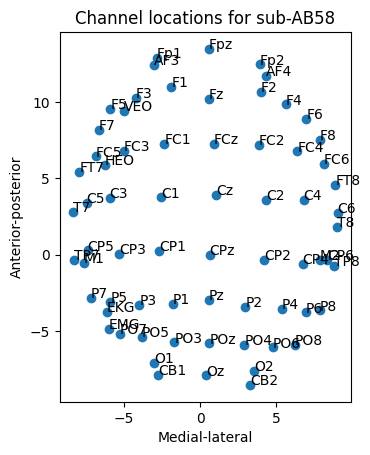

In [12]:
def plot_scalp(chan_locs, chan_names, subj):
    fig, ax = plt.subplots()
    ax.scatter(chan_locs[:,0], chan_locs[:,1])
    for ind, name in enumerate(chan_names):
        ax.text(chan_locs[ind,0], chan_locs[ind,1], name)
    ax.set_xlabel('Medial-lateral')
    ax.set_ylabel('Anterior-posterior')
    ax.set_title('Channel locations for {}'.format(subj))
    ax.set_aspect('equal')

plot_scalp(chan_locs, chan_names, subj)

Another useful piece of info in the eeg data is 'ref'.

In [13]:
ref_elec = eeg['ref']
var_inspector(ref_elec)

Type: <class 'numpy.ndarray'>
['between_Cz_and_CPz']


Another numpy array with a string inside. Let's extract the channels the reference was between, and then use their coordinates to plot where the reference was.

Reference channel was near: ['Cz', 'CPz']
Coordinates of electrodes near reference: [[ 1.03  3.91  8.48]
 [ 0.63 -0.01  8.41]]
Coordinates of reference: [0.83 1.95 8.44]


Text(0.82986, 1.9503460000000001, 'REF')

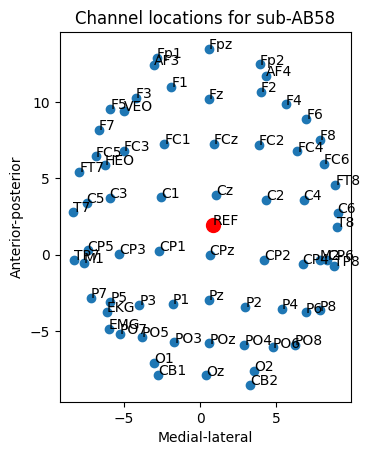

In [14]:
# split the reference string at underscores and return the channel names
near_ref_names = [ref for ref in ref_elec[0].split('_') if ref in chan_names]

print('Reference channel was near: {}'.format(near_ref_names))


# get the coordinates of the reference electrodes
near_ref_coords = [chan_locs[chan_names.index(ref)] for ref in near_ref_names]
#
print('Coordinates of electrodes near reference: {}'.format(np.round(near_ref_coords,2)))   

# print near ref coords with only 2 decimal places

# get the average of the coordinates
ref_coord = np.mean(near_ref_coords, axis=0)
print('Coordinates of reference: {}'.format(np.round(ref_coord,2)))

# plot the reference electrode
plot_scalp(chan_locs, chan_names, subj)
plt.scatter(ref_coord[0], ref_coord[1], c='r', s=100)
plt.text(ref_coord[0], ref_coord[1], 'REF')

With all this out of the way, let's inspect the EEG data itself.

In [15]:
eeg_data = eeg['data']
var_inspector(eeg_data)

Type: <class 'numpy.ndarray'>
[[-17487.854   -17494.352   -17504.037   ... -17945.916   -17952.68
  -17949.879  ]
 [-22107.213   -22104.95    -22108.615   ... -22745.281   -22717.625
  -22711.635  ]
 [ -5888.045    -5887.7466   -5885.6606  ...  -5802.661    -5804.211
   -5797.6245 ]
 ...
 [ -1053.0055   -1051.8431   -1050.8597  ...   -422.0903    -421.13663
    -418.2458 ]
 [     0.           0.           0.      ...      0.           0.
       0.     ]
 [     0.           0.           0.      ...      0.           0.
       0.     ]]


Another numpy array, but this one contains a lot of numeric data. We can get the number of channels and time points that were recorded.

In [16]:
nchan = eeg_data.shape[0]
nsamp = eeg_data.shape[1]
print('Number of samples: {}'.format(nsamp))
print('Duration of recording: {} seconds'.format(nsamp/srate)) # dividing number of samples by sampling rate gives the duration of the recording
print('Number of channels: {}'.format(nchan))

Number of samples: 132480
Duration of recording: 264.96 seconds
Number of channels: 66


Uh oh, the number of channels, 66, does not match the number given in chaninfo, 68. Perhaps we can find the correct values in the file *_channels.tsv.

In [17]:
# load the a *_channels.tsv file
subj = 'sub-AB58'
chan_dir = ['data', 'ds003690', subj, 'eeg', '{}_task-passive_run-1_channels.tsv'.format(subj)]
chan_file = op.join(*chan_dir) # use * to unpack the list
channels = pd.read_csv(chan_file, sep='\t')
print(channels)

            name   type units
0            AF3    EEG    uV
1            AF4    EEG    uV
2             F7    EEG    uV
3             F5    EEG    uV
4             F3    EEG    uV
..           ...    ...   ...
61           VEO   VEOG    uV
62           HEO   HEOG    uV
63           EKG    ECG    uV
64  R-Dia-X-(mm)  PUPIL    mm
65  R-Dia-Y-(mm)  PUPIL    mm

[66 rows x 3 columns]


Notice how the number of channels listed in the .tsv file is the same as those in our EEG data. This is probably the correct file for figuring out where each channel was recorded. 

The .tsv file type stands for *tab separated values*. It is a table of data stored in a text file, where each row is a different line, and each column is separated by a tab. Often the first line of text gives the names for each column, but this is not necessary. It looks like this if you open in a text editor:
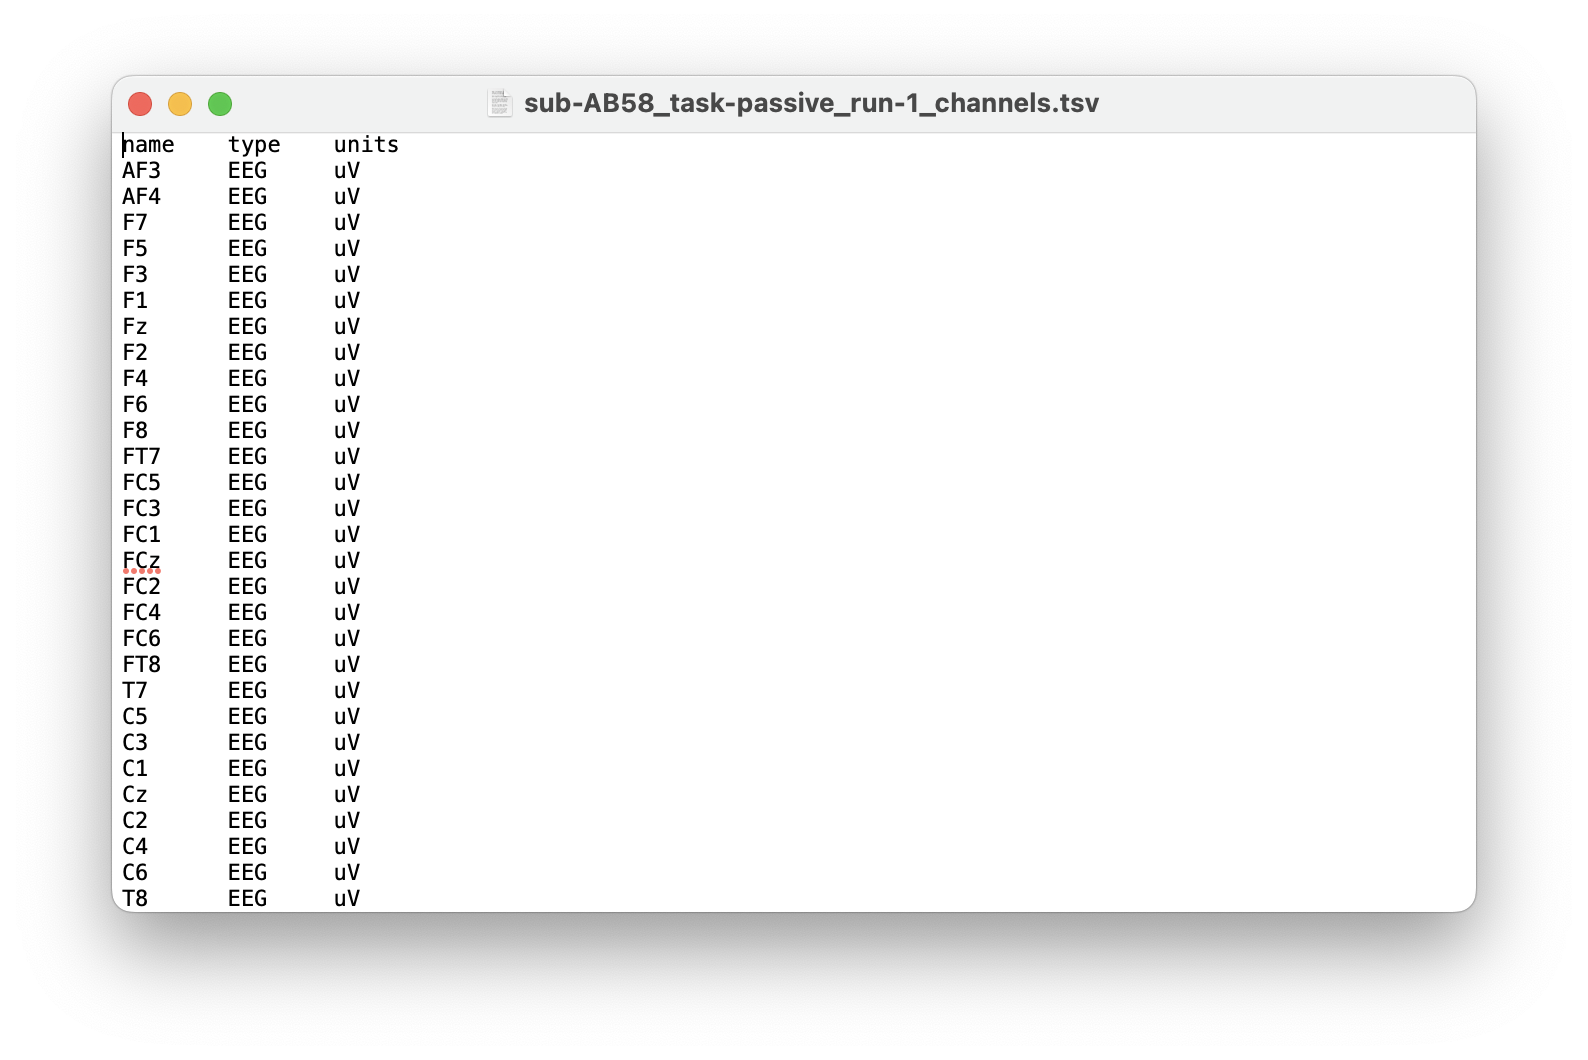

It is difficult to compare the list of recording sites in chaninfo and the _channels.tsv by eye, but we can write some code to solve that problem.


In [18]:
# pull the channel names from the channels tsv file
chan_names_tsv = channels['name'].tolist()

# identify the channels in chan_names that are not in chan_names_tsv
missing_chan = [chan for chan in chan_names if chan not in chan_names_tsv]
print('The missing channels are: {}'.format(', '.join(missing_chan)))

The missing channels are: Fp1, Fpz, Fp2, EMG


We should set `chan_names` to the list in the _channel.tsv file and match those with the electrode locations from the _eeg.set file.

In [19]:
chan_info = pd.DataFrame({'name': chan_names, 
                             'ML': chan_locs[:,0], 
                             'AP': chan_locs[:,1], 
                             'DV': chan_locs[:,2]})
channels = pd.merge(channels, chan_info, how='left', on='name')
channels

,name,type,units,ML,AP,DV
0,AF3,EEG,uV,-3.023524,12.428141,1.361401
1,AF4,EEG,uV,4.304501,11.727693,0.427403
2,F7,EEG,uV,-6.639328,8.170529,-1.526560
3,F5,EEG,uV,-5.876012,9.542894,0.800148
4,F3,EEG,uV,-4.229360,10.265764,2.418731
...,...,...,...,...,...,...
61,VEO,VEOG,uV,-4.985376,9.402884,-3.997588
62,HEO,HEOG,uV,-6.256028,5.891592,-6.051630
63,EKG,ECG,uV,-6.121837,-3.762735,-10.496158
64,R-Dia-X-(mm),PUPIL,mm,NaN,NaN,NaN


Note that there are a few extra channels with names that are not part of the EEG site naming scheme given above. 'VEO' and 'HEO' are electrodes placed near the left eye and can detect eye movements (discussed below). 'EKG' is from an electrode place near the heart and gives the *electrocardiogram*, which captures the electrical activity associated with heart beats. Lastly, 'R-Dia-X-(mm)' and 'R-Dia-Y-(mm)' are measures of pupil diameter made by a video camera trained on the eye.

And now we can replot the EEG electrodes, with the missing channels removed.

Text(0.82986, 1.9503460000000001, 'REF')

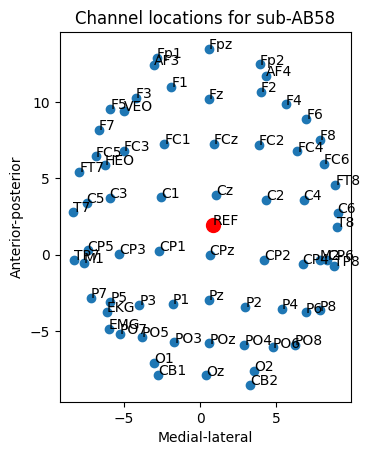

In [20]:
plot_scalp(chan_locs, chan_names, subj)
plt.scatter(ref_coord[0], ref_coord[1], c='r', s=100)
plt.text(ref_coord[0], ref_coord[1], 'REF')

The next thing to inspect is the EEG signal itself. The EEG signal is an array of voltages, $EEG$, sampled at each channel, $ch$ and time point, $t$. A single sample can be written as $EEG_{ch,t}$. If we want the voltage across all channels at a specific time that would be the vector $EEG_{t}$. The entire time series of voltages from a single channel is expressed as $EEG_{ch}$. The term *time series* is important to keep in mind. Virtually all the data we will work with is time series data, meaning that it is the values generated by some process that is sampled at regular intervals. In the case of our present EEG signal, this would be the uV potentials recorded from an electrode at the sample rate (`srate`) of 500 Hz.

To begin exploring this data, lets the voltage detected on channel O1 between 50 and 52 seconds. We will express this as:
$$ EEG_{O1}[50\leq t \le 52] $$

First, we identify the index for the row containing data from channel O1.

In [21]:
# select channel to plot
sel_chan = 'O1'
chan_ind = channels.index[channels['name']==sel_chan]

Using the `channels` dataframe we generated above, we find the row where the 'name' column is equal to O1, and then return the index of that row. The indices in the `channels` dataframe range from 0 to 65, with each corresponding to a row in `eeg_data`.

Next we need to find the time points that were sampled between 50 and 52 seconds into the recording.

In [22]:
# set the times we wish to plot
start_t = 50
end_t = 52
start_idx = (start_t*srate).astype(int)
end_idx = (end_t*srate).astype(int)

Since our recording starts at time point 0 seconds and was recorded with `srate` number of samples per second, we can find the indices of the start and stop times by multiplying those times in seconds by the `srate` (`start_t*srate` and `end_t*srate`). Since these will be used to index into an array, we ensure that they have integer values by forcing them to an integer datatype using the numpy `astype` function.

In [23]:
# extract the eeg data we wish to plot
eeg_epoch = eeg_data[chan_ind, start_idx:end_idx].squeeze() # squeeze removes the extra dimension

An 'epoch' is a period of time, and when we pull out a contiguous set of values from a time series will refer to that as an epoch. When plotting that data, we need to pass both the eeg signal and their corresponding time points. These can either be *absolute* or *relative*. For absolute, the time values are taken with respect to the entire recording, so in our case they would start at 50 sec and end just before 52 sec. For relative time, the times at taken with respect to a specific event (usually the beginning of our epoch, but not always). In that case, they would start at 0 sec and end just before 2 sec. Calculating either is straightforward:

In [24]:
# time on an absolute scale
t_abs_epoch = start_t + np.arange(0, eeg_epoch.size)/srate

# time on a relative scale
t_rel_epoch = np.arange(0, eeg_epoch.size)/srate

Now let's plot on both time scales, just for show.

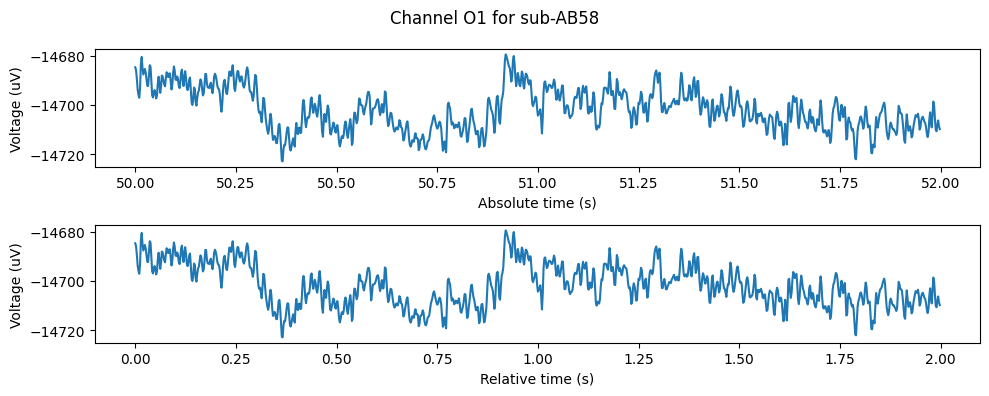

In [25]:
fig, ax = plt.subplots(2,1,figsize=(10,4))
ax[0].plot(t_abs_epoch, eeg_epoch) # we transpose to make the data the right shape for plotting
ax[0].set_xlabel('Absolute time (s)')
ax[0].set_ylabel('Voltage (uV)')
ax[1].plot(t_rel_epoch, eeg_epoch)
ax[1].set_xlabel('Relative time (s)')
ax[1].set_ylabel('Voltage (uV)')
fig.suptitle('Channel {} for {}'.format(sel_chan, subj))
fig.tight_layout()

This is the electrical activity recorded on the scalp over the left occipital cortex, an area of the brain involved in visual processing. The signal has a somewhat noisy appearance, though it is unclear what is really 'noise.' 

Before we move on, let's create a class for loading the EEG data from a file and giving us access to it.

In [26]:
class EEG:
    def __init__(self, eeg_file, chan_file):
        """
        A class for loading and plotting EEG data

        Parameters
        ----------
        eeg_file : str, path to the .set file
        chan_file : str, path to the _channels.tsv file
        """

        # load the eeg data
        self._eeg = sio.loadmat(eeg_file)
        data = self._eeg['data']
        self.srate = self._eeg['srate'][0,0]
        self.data = data
        self.nchan = self.data.shape[0]
        self.nsamp = self.data.shape[1]
        self.dur = self.nsamp/self.srate

        # load the channel info and integrate with locations
        chan_info = self._eeg['chaninfo'][0,0][1]
        chan_names = [name.split()[0] for name in chan_info]
        chan_locs = np.array([name.split()[2:] for name in chan_info], dtype=float)
        chan_info = pd.DataFrame({'name': chan_names, 
                                    'ML': chan_locs[:,0], 
                                    'AP': chan_locs[:,1], 
                                    'DV': chan_locs[:,2]})
        chans = pd.read_csv(chan_file, sep='\t')
        chans = pd.merge(chans, chan_info, how='left', on='name')
        self.chans = chans

        # get reference electrode position
        ref_elec = self._eeg['ref'][0]
        near_ref_names = [ref for ref in ref_elec.split('_') if ref in chans['name'].tolist()]
        near_ref_chans = chans[chans['name'].isin(near_ref_names)]
        near_ref_coords = near_ref_chans[['ML', 'AP', 'DV']].to_numpy()
        self.ref_coord = np.mean(near_ref_coords, axis=0)

    def get_data(self, chans=None, start_t=0, dur_t=None, scale='absolute'):
        """
        Extract EEG data from the EEG object

        Parameters
        ----------
        chans : list of str, the channels to extract
        start_t : numeric array, the start times in seconds
        dur_t : float, the duration in seconds
        scale : str, 'absolute' or 'relative'

        Returns
        -------
        data_epochs : 3d array, the eeg data
        tpts : 1d array, the time vector
        chans : list of str, the channels extracted
        """

        # ensure proper formatting of inputs
        if not chans:
            chans = self.chans['name']
        elif chans == 'eeg': # only extract eeg channels
            chans = self.chans[self.chans['type']=='EEG']['name'].values
        if not dur_t:
            dur_t = self.dur-start_t
        start_t = np.array(start_t)
        start_t = start_t.ravel()
        epoch_num = start_t.size

        # convert times to indices
        start_idxs = (start_t*self.srate).astype(int)
        dur_idx = (dur_t*self.srate).astype(int)
        end_idxs = start_idxs + dur_idx

        # get the channel indices
        chan_idxs = self.chans.index[self.chans['name'].isin(chans)]

        # extract the eeg data, one epoch at a time
        data_epochs = np.zeros((dur_idx, len(chan_idxs), epoch_num))
        for i in range(epoch_num):
            data_epochs[:,:,i] = self.data[chan_idxs, start_idxs[i]:end_idxs[i]].T

        # get the time vector
        if scale == 'absolute':
            tpts = start_t + np.arange(0, dur_idx)/self.srate
        elif scale == 'relative':
            tpts = np.arange(0, dur_idx)/self.srate
        
        return data_epochs, tpts, chans

    def plot_scalp(self, ax=None, colors='b'):
        """
        Plot the channel locations on the scalp
        """

        # ensure proper formatting of inputs
        if not ax:
            fig, ax = plt.subplots()
        
        chans = self.chans[self.chans['type']=='EEG']

        # plot the channel locations
        ax.scatter(chans['ML'], chans['AP'], c=colors)
        for ind, name in enumerate(chans['name']):
            ax.text(chans['ML'][ind], chans['AP'][ind], name)
        
        # plot the reference electrode
        ax.scatter(self.ref_coord[0], self.ref_coord[1], c='k', s=100)
        
        ax.set_xlabel('Medial-lateral')
        ax.set_ylabel('Anterior-posterior')
        ax.set_title('Channel locations for {}'.format(subj))
        ax.set_aspect('equal')

        return ax

Now let's give this class a try. It should shorten all the code we did above.

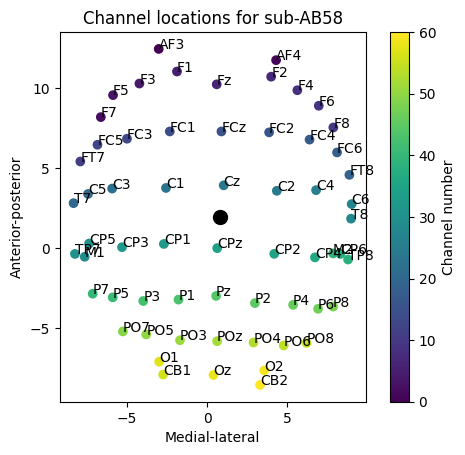

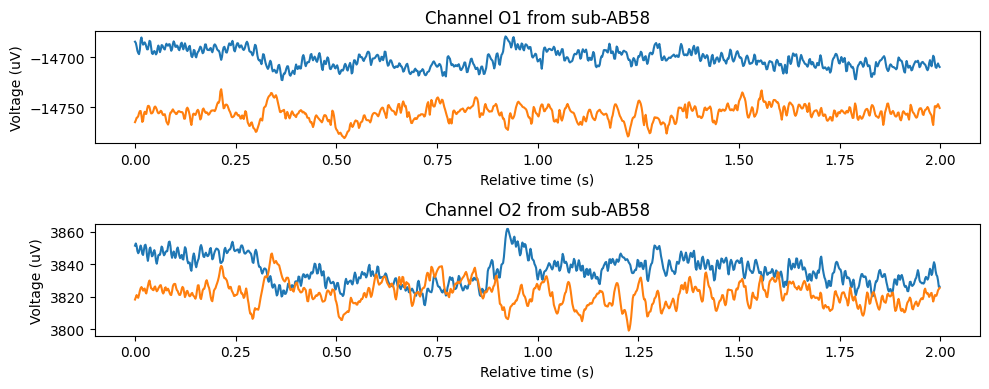

In [27]:
# get file paths
subj = 'sub-AB58'
chan_dir = ['data', 'ds003690', subj, 'eeg', '{}_task-passive_run-1_channels.tsv'.format(subj)]
chan_file = op.join(*chan_dir) # use * to unpack the list
data_dir = ['data', 'ds003690', subj, 'eeg', '{}_task-passive_run-1_eeg.set'.format(subj)]
eeg_file = op.join(*data_dir) # use * to unpack the list

# create an EEG object
eeg = EEG(eeg_file, chan_file)

# plot the scalp
eeg_chan_num = np.sum(eeg.chans['type']=='EEG')
scalp_ax = eeg.plot_scalp(colors=range(eeg_chan_num))
plt.colorbar(scalp_ax.collections[0], ax=scalp_ax, label='Channel number')

# get the 2 channels of eeg data at 2 time points
eeg_epochs, tpts, chans = eeg.get_data(chans=['O1', 'O2'], start_t=[50, 100], dur_t=2, scale='relative')

# plot the eeg data
fig, ax = plt.subplots(2,1,figsize=(10,4))
ax[0].plot(tpts, eeg_epochs[:,0,:])
ax[0].set_xlabel('Relative time (s)')
ax[0].set_ylabel('Voltage (uV)')
ax[0].set_title('Channel {} from {}'.format(chans[0], subj))
ax[1].plot(tpts, eeg_epochs[:,1,:])
ax[1].set_xlabel('Relative time (s)')
ax[1].set_ylabel('Voltage (uV)')
ax[1].set_title('Channel {} from {}'.format(chans[1], subj))
fig.tight_layout()

### Time series statistics
Now that we can easily load in EEG data, and let's explore some of the statistics we use to summarize it. Since the EEG signal is a series of voltages sampled at evenly spaced time intervals, we will make use of the statistical measures used for time series data more generally. To start, we will reload the EEG epoch we started with using our new EEG data class.

In [28]:
eeg_data, eeg_t, eeg_chan = eeg.get_data(chans=['O1'], start_t=50, dur_t=2, scale='absolute')
eeg_data = eeg_data.ravel() # ravel flattens the array

#### Mean
Time series data is often considered to be the repeated sampling of an ongoing process. The values given off by that process will have a distribution, and if that distribution is normal then the two measures that characterize that distribution are its *mean* and *variance*.

$$ Mean = E[X] = \frac{1}{n}\sum_{t=1}^{n}X_{t} $$ 

To translate, the Mean can be written as a function $E[X]$, which stands for the **E**xpected value of X. The expected value is equal to the sum ($\sum$) from the first ($t=1$) to the last ($n$) value of each individual ($t$) time point of $X$, expressed as $X_{t}$, divided by the number of time points ($n$). The corresponding explicit code for this is:

In [29]:
# A method that explicitly expresses how to calculate the mean in base python
def mean(x):
    sum = 0
    n = len(x)
    for t in range(0,n):
        sum += x[t]

    return sum / n

Assuming our data has a normal distribution, the mean tells us which value is most likely to be expressed at any given moment. In the case of the EEG epoch we have above, this value is:

In [30]:
eeg_data_mean = mean(eeg_data)
print('Mean of the EEG epoch: {:.2f} uV'.format(eeg_data_mean))

Mean of the EEG epoch: -14701.82 uV


#### Variance
Besides them mean, we also want a measure of the variability in the voltage around the mean. A measure frequently used is the *variance*. It is calculated as:
$$ Variance = Var[X] = E[(X-E[X])^2] = \frac{1}{n}\sum_{t=1}^{n}(X_{t}-E[X])^2 $$

The variance is the mean of the squared difference between the values in our time series and the mean value. This too we can cast explicitly in code:

In [31]:
# A method that explicitly expresses how to calculate variance in base python
def variance(x):
    sum = 0
    n = len(x)
    e_x = mean(x)
    for t in range(0,n):
        sum += (x[t] - e_x)**2

    return sum / n

eeg_data_var = variance(eeg_data)
print('Variance of the EEG epoch: {:.2f} uV^2'.format(eeg_data_var))

Variance of the EEG epoch: 71.67 uV^2


#### Standard deviation
Notice that the variance is in units of uV<sup>2</sup>. Since we analyze EEG is measured in uV, it is difficult for us to directly interpret the variance. Instead, we can take its square root, giving us a measure the of the variability in the EEG signal that is in units of uV. The square root of the variance is the familiar *standard deviation*. If we measure the standard deviation of our EEG epoch, we get:

In [32]:
# A method that explicitly expresses how to calculate standard deviation in base python
def sd(x):
    return variance(x)**(1/2)

eeg_data_sd = sd(eeg_data)
print('Standard deviation of the EEG epoch: {:.2f} uV'.format(eeg_data_sd))

Standard deviation of the EEG epoch: 8.47 uV


#### The normal distribution
If a signal is normally distributed, then all we need to approximate its distribution is its expected value and variance. The normal distribution is captured by the curve:
$$ p(X_{i}) = \frac{1}{\sqrt{Var[X]2\pi}}exp\left[{-\frac{(X_{i}-E[X])^{2}}{2Var[X]}}\right]$$

Translating this into code we get:

In [33]:
# A method that explicitly expresses how to calculate the probability of a 
# data point being observed given a normal distribution
def normal(x, x_i):
    e_x = mean(x)
    v_x = variance(x)
    scale_factor = (1/((2*np.pi*v_x)**(1/2))) # sets the height of the curve
    shape_factor = np.exp(-((x_i - e_x)**2)/(2*v_x)) # sets the width of the curve
    return scale_factor * shape_factor

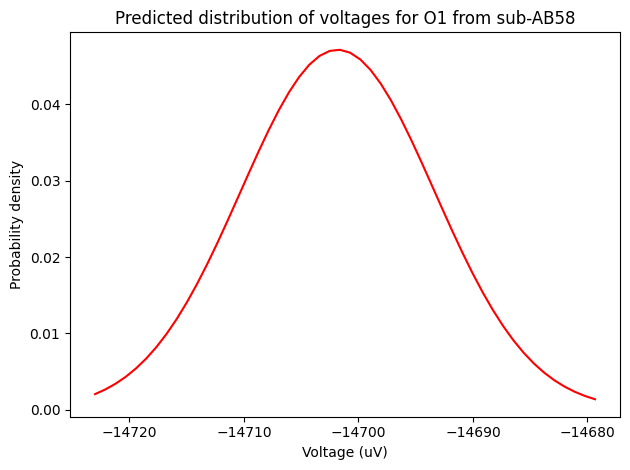

In [34]:
samp_vals = np.linspace(np.min(eeg_data), np.max(eeg_data), 50)
norm_vals = [normal(eeg_data, samp) for samp in samp_vals]

fig, ax = plt.subplots()
ax.plot(samp_vals, norm_vals, c='r')
ax.set_xlabel('Voltage (uV)')
ax.set_ylabel('Probability density')
ax.set_title('Predicted distribution of voltages for {} from {}'.format(sel_chan, subj))
fig.tight_layout()


How does this predicted distribution compare with the actual distribution of values? To answer this question, we need to plot the probability of a particular value occuring in our EEG epoch. We could try plotting the values as hatch marks at the bottom of the graph, and see if their density is highest near the center of the normal curve.

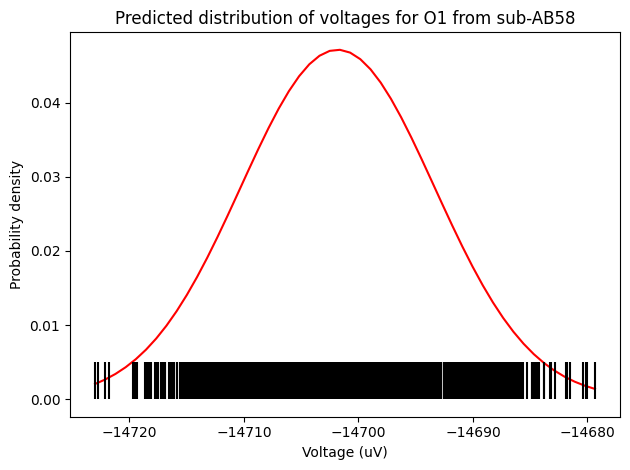

In [35]:
# plot the normal distribution, and short vertical lines on the x-axis where each data point from eeg_epoch is
fig, ax = plt.subplots()
ax.plot(samp_vals, norm_vals, c='r')
ax.set_xlabel('Voltage (uV)')
ax.set_ylabel('Probability density')
ax.set_title('Predicted distribution of voltages for {} from {}'.format(sel_chan, subj))
ax.vlines(eeg_data, 0, 0.005, color='k')
fig.tight_layout()


In this graph, each voltage sample is represented as a single vertical line (which we will refer to as hatch marks), with its position on the voltage axis determined by its value. It appears that they are clustered near the center of the normal distribution. Indeed, the density of hatch marks there is so high that they fuse together into a single black mass. It would be better if we could estimate the density of hatch marks along the voltage axis. To do this, we will calculate a *histogram*, which divides the voltage axis into a series of *bins* and measures the number of data points in each bin. These counts are then scaled by the number of data points, $n$, and the length of the bin to give us probability density. Here is how we can code this:

In [36]:
# A method that explicitly expresses how to calculate a probability density histogram
def histogram(x, bin_num):
    n = len(x)
    x_min = min(x)
    x_max = max(x)
    bin_width = (x_max - x_min)/bin_num
    bin_edges = x_min + bin_width * range(bin_num+1)
    bin_centers = np.zeros(bin_num)
    bin_heights = np.zeros(bin_num)
    scale_factor = 1/(n*bin_width)
    for i in range(0,bin_num):
        bin_count = len(x[(x >= bin_edges[i]) & (x < bin_edges[i+1])])
        bin_heights[i] = (scale_factor * bin_count)
        bin_centers[i] = (bin_edges[i] + bin_width/2)
    return bin_centers, bin_heights
    

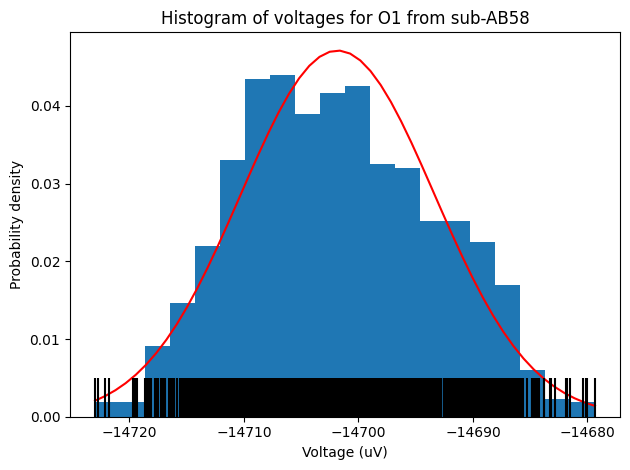

In [37]:
# calculate the empirical distribution of the EEG data
bin_centers, bin_heights = histogram(eeg_data, 20)

# plot the empirical distribution
bin_width = bin_centers[1]-bin_centers[0]
fig, ax = plt.subplots()
ax.bar(bin_centers, bin_heights, width=bin_width, align='center')
ax.plot(samp_vals, norm_vals, c='r')
ax.vlines(eeg_data, 0, 0.005, color='k')
ax.set_xlabel('Voltage (uV)')
ax.set_ylabel('Probability density')
ax.set_title('Histogram of voltages for {} from {}'.format(sel_chan, subj))
fig.tight_layout()

Now we have a much better sense of the distribution of the EEG values. We can see that they generally follow the contours of the normal distribution, but not perfectly. There is an overabundance of low values, and fewer values around the mean. Looking back at the plot of our EEG snippet, it appears that the signal wanders, with periods of low values and high values. This might explain the deviation from a normal distribution. 

Adjacent samples in the time series tend to have similar values. This is unlike most other data you may have wokred with, such as tabular data, where each data point is sampled independently from the others. In the case of time series data, adjacent samples will be necessarily related to each other since they were obtained near the same time. Is there a way to quantify this?

#### Autocovariance
What we want is a measure of the similarity between samples in our time series as a function of how apart they are in time. If adjacent samples tend to both be above or below the mean, we want our measure to be high, and we want to it to be near zero when they are unrelated. The autocovariance function behaves this way.

$$ ACov[\tau] = E[(X_{t}-E[X])(X_{t+\tau}-E[X])]$$

Put in words, we create a new time series, $(X_{t}-E[X])(X_{t+\tau}-E[X])$, by multiplying a mean subtracted version of our time series by itself at some fixed time lag ($\tau$), and then measure the mean value of this new time series. We do this for a range of lags. In code, this looks like:

In [38]:
# A method that explicitly expresses how to calculate the autocovariance of a signal
def autocovariance(x, lag):
    n = len(x)
    e_x = mean(x)
    sum = 0
    for t in range(0,n-lag):
        sum += (x[t] - e_x)*(x[t+lag] - e_x)
    return sum / (n-lag)

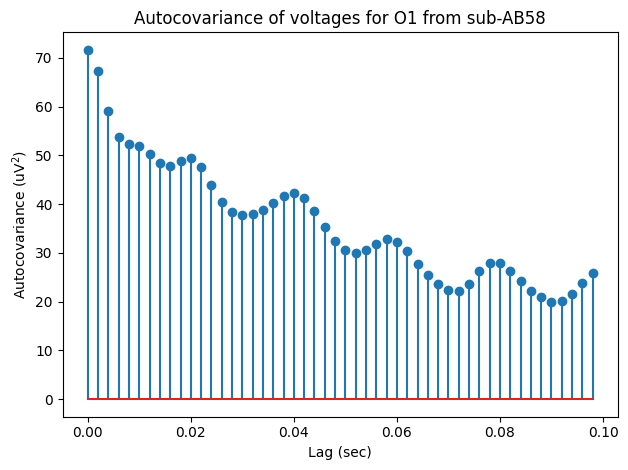

In [39]:
# Calculate autocovariance for lags 0 to 20
lags = range(0,50)
autocov = [autocovariance(eeg_data, lag) for lag in lags]

# Since our sample rate is 500 Hz, we can convert the lags to time in seconds
lags_sec = np.array(lags)/srate

# Plot autocovariance as stem plot
fig, ax = plt.subplots()
ax.stem(lags_sec, autocov)
ax.set_xlabel('Lag (sec)')
ax.set_ylabel('Autocovariance (uV$^2$)')
ax.set_title('Autocovariance of voltages for {} from {}'.format(sel_chan, subj))
fig.tight_layout()


A few things stand out here. First, when the lag is 0 sec, the value of the autocovariance is the same as the variance we estimated earlier (71.7 uV<sup>2</sup>). This is because for the zero lag case, the equation for autocovariance and variance are exactly the same. Second, as we increase the lag the autocovariance decreases, indicating that samples farther apart in time are less similar to each other. Lastly, you can see some periodic ripples riding on the autocovariance at 20, 40, 60, and 80 ms. It is no coincidence that these are evenly spaces 20 ms apart. They are due to contamination by power line noise, which is at a frequency of 50 Hz in Europe, where this data was obtained. We will discuss this further in the next section.

#### Numpy
Note that the Numpy package has methods for calculating the mean (`np.mean`), variance (`np.var`), and standard deviation (`np.std`). These offer far greater control over how these operations are carried out with multidimensional arrays, and so you should use them. As an example, let's rewrite the autocovariance function using Numpy methods, since Numpy does not have one built-in.

In [40]:
# A method that calculates the autocovariance of a signal using numpy methods
def autocovariance(x, lag):
    n = len(x)
    e_x = np.mean(x)
    return np.sum((x[0:n-lag] - e_x)*(x[lag:n] - e_x)) / (n-lag)

### Artifacts and noise
Environmental electrical noise that is homogenous across the head will be elimited by the proper referencing described above. However, there are other sources of electrical interference that are not homogenous across this head. This is especially true for those arising from the head itself. Recall from our discussion of extracellular potentials that voltage falls off with distance. This means that electrodes close to a location on the head producing non-neural electrical signals will record very different signals. In contrast, the differnce between noise sources far from the head will be much smaller. 

These sources are sometimes referred to as noise, and other times as artifacts. Common sources are skin potentials, the eye movements and blinks (electrooculogram), muscle movements (electromyogram), and power line interference. Thus, we can conceive of the EEG as a sum of neural and non-neural sources:

$$ EEG = Neural + EOG + ACPower + EMG + Scalp $$

Let's consider each of these non-neural sources, and how to eliminate them.

#### Skin potentials
The skin is a conductive medium with its own voltage potential between its inside and outside. This voltage changes with the skin's conductivity. Often this occurs slowly over time by the opening and closing of sweat glands and the hydration of the skin by the conductive gel. It can also change suddenly when the electrode contact is moved. Often this potential can be corrected for calculating the mean potential on an electrode shortly before the moment we want to analyze, and subtracting it out.

[PICTURE OF SKIN ANATOMY]

To see how much the skin potential can drift, take a look at our EEG recording, but now for the entire recording duration.

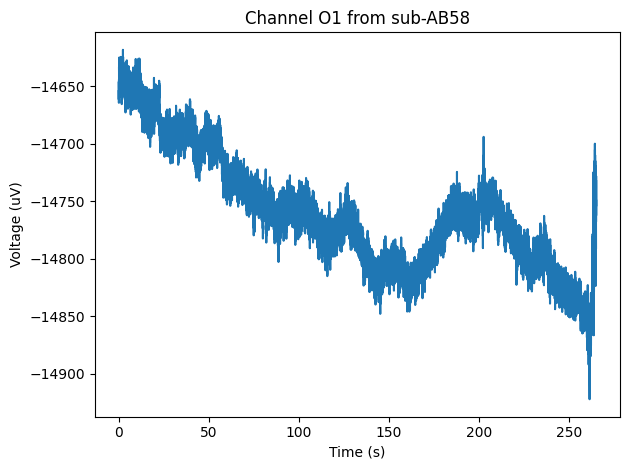

In [41]:
# load entire O1 channel EEG recording
eeg_data_full, eeg_t_full, eeg_chan_full = eeg.get_data(chans=['O1'])
eeg_data_full = eeg_data_full.ravel()

# plot full eeg recording
fig, ax = plt.subplots()
ax.plot(eeg_t_full, eeg_data_full)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('Channel {} from {}'.format(eeg_chan_full[0], subj))
fig.tight_layout()


The level of the EEG varies greatly over the 4 minutes of the recording. It's offset starts around -14,650 uV, and drifts down to -14,850 uV, spanning a range of 200 uV. This far exceeds the standard deviation of the signal, which we calculated over a short segment above at ~8.5 uV. 

This is only on a single electrode. How heterogenous are these offsets and drifts across electrodes?

Minimum mean voltage: -22535.51 uV
Maximum mean voltage: 8960.47 uV


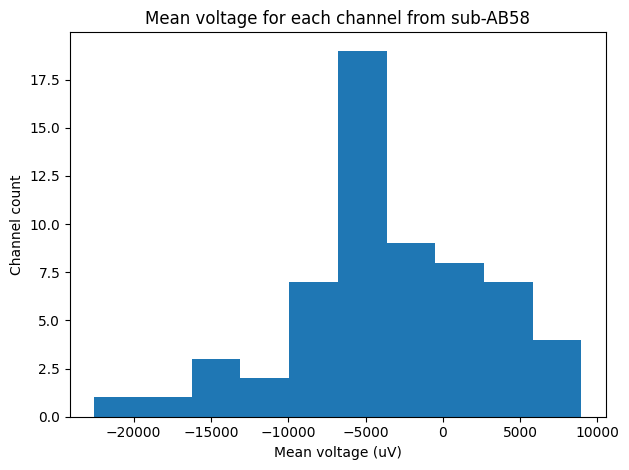

In [42]:
# load all eeg data
eeg_data_full, eeg_t_full, eeg_chan_full = eeg.get_data(chans='eeg')

# get mean voltage from each channel
eeg_mean = np.mean(eeg_data_full, axis=0).ravel()

# plot the mean voltage for each channel on the scalp
fig, ax = plt.subplots()
ax.hist(eeg_mean)
ax.set_xlabel('Mean voltage (uV)')
ax.set_ylabel('Channel count')
ax.set_title('Mean voltage for each channel from {}'.format(subj))
fig.tight_layout()

print('Minimum mean voltage: {:.2f} uV'.format(np.min(eeg_mean)))
print('Maximum mean voltage: {:.2f} uV'.format(np.max(eeg_mean)))

There is a wide range of mean voltages across the channels, from -22.5 mV to 8.9 mV. How do they change with time? We saw that site O1 drifted towards more negative voltages, but was that also the case for the other channels? Let's look at a few channels spread across the scalp.

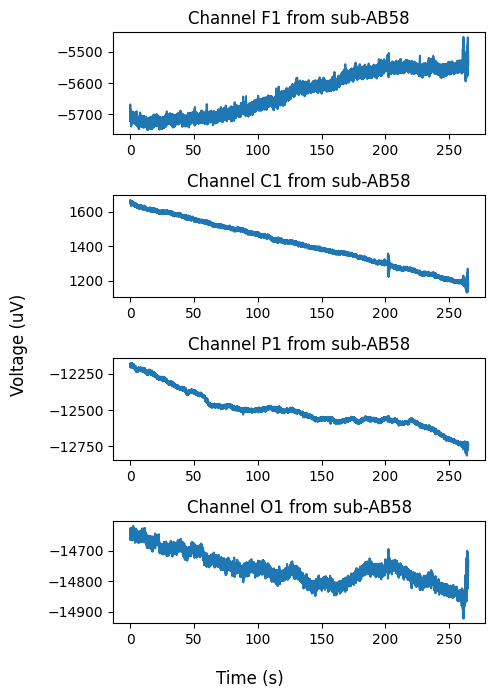

In [43]:
drift_chans = ['F1', 'C1', 'P1', 'O1']

# get the eeg data for the drift channels
eeg_data_drift, eeg_t_drift, eeg_chan_drift = eeg.get_data(chans=drift_chans)

# plot the eeg data for the drift channels
fig, ax = plt.subplots(4,1,figsize=(5,7))
for i in range(4):
    ax[i].plot(eeg_t_drift, eeg_data_drift[:,i,:])
    ax[i].set_title('Channel {} from {}'.format(eeg_chan_drift[i], subj))
fig.supxlabel('Time (s)')
fig.supylabel('Voltage (uV)')
fig.tight_layout()

Not all channels show the same slow drift in their potential. F1 drifted up, while C1, P1, and O1 drift down. C1 drifts down as a straight line, while P1 and O1 take wobbly paths. We want to eliminate these offsets. One way we could do this is to get a *running average* of the voltage and then subtract it from the original. This would eliminate the large offset and its slow drift, leaving only the fast fluctuations.

To calculate a running average, we will calculate the mean value of the time series over a fixed interval. We do this for each time point in the series, giving us a new time series with the same length as the original, but whose values are the local average. Mathematically, we can represent this as:

$$ Y_{t} = \frac{1}{2w+1}\sum_{\tau=-w}^{w}{X_{t+\tau}} \tag{1}$$

The size of the window we use is specified by $n$. The larger $n$ we choose, the more data points we average together and moving average will reflect slower trends in the time series. At the limits, if $w$ is equal to 0, then we get the exact same time series back. This is useless for our purposes, because if we subtract it from the original time series we are left with nothing. On the other hand, as we increase $w$ the values in our moving average time series approach its mean value. This would capture the offset, but it would miss the trend. Thus, we want to set $w$, which we will now refer to as our *window size*, to a value that is small enough to capture the drift in our time series, but not so small that it just recapitulates the time series and eliminates the signals we care about. 

To explore these issues, code a moving average function with a parameter that controls window size.

In [44]:
# A method that calculates a moving average
def moving_average(x, w):
    n = len(x)
    y = np.zeros(n)
    for t in range(0,n):
        if t < w: # if we are at the beginning of the signal
            y[t] = np.mean(x[0:t+w])
        elif t > n-w: # if we are at the end of the signal
            y[t] = np.mean(x[t-w:n])
        else: # if we are in the middle of the signal, same as equation 1
            y[t] = np.mean(x[t-w:t+w])
    return y

Before we apply this function to our data, a quick comment about how this code handles the beginning and end of the signal. Our window spans timepoints from `-w` to `w`, so if we are at the start of the signal then the samples from `-w` that would have gone into our average are not available, and likewise for the end of the signal with points on the `w` end. The approach taken here was to just take the mean of the points we did have. Another approach is to *pad* the edges of the signal, place a number `w` times at the begginning and end. If the number is 0, it is called *zero padding*. A problem with zero padding is that the mean will be distorted by those zeros early and late in the signal. Those distortions are referred to as *edge effects*. Alternative padding strategies can mitigate edge effects. For instance, instead of padding with zero you can use the value for the first or last sample, and pad with that. Or, you can reflect the signal at the edges.

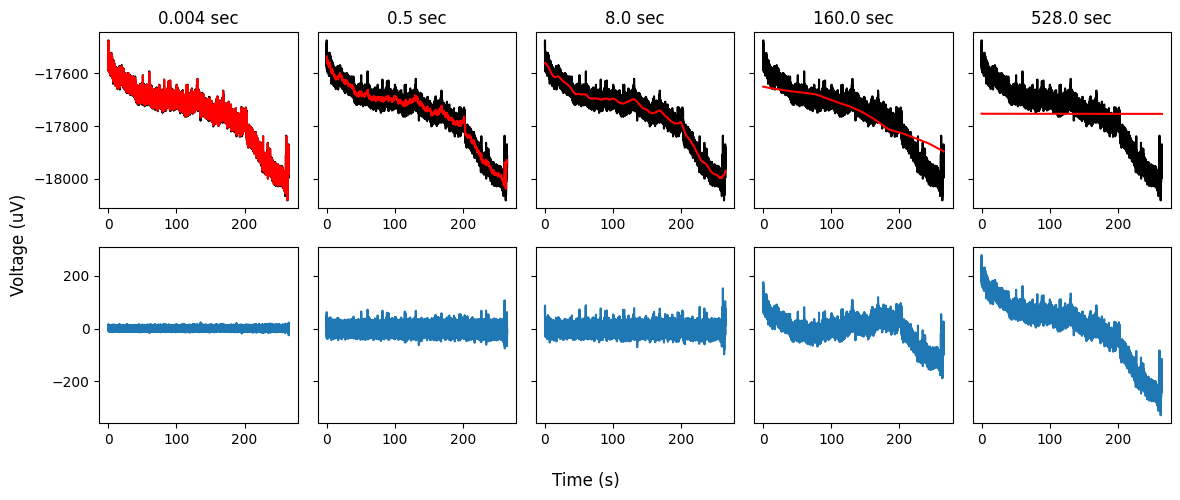

In [45]:
# Try out the moving average function with different windows
w = [1, 125, 2000, 40000, 132000]
fig, ax = plt.subplots(2,5,figsize=(12,5), sharey='row')
for i in range(5):
    eeg_ma = moving_average(eeg_data_full[:,0], w[i])
    eeg_resid = eeg_data_full[:,0].ravel() - eeg_ma
    ax[0,i].plot(eeg_t_full, eeg_data_full[:,0],color='k')
    ax[0,i].plot(eeg_t_full, eeg_ma, color='r')
    ax[0,i].set_title('{} sec'.format(2*w[i]/eeg.srate))
    ax[1,i].plot(eeg_t_full, eeg_resid)
fig.supxlabel('Time (s)')
fig.supylabel('Voltage (uV)')
fig.tight_layout()

The top row shows the original signal in black, with the moving average overlaid on top in red. The bottom row of graphs with blue lines is the difference between the original EEG signal and the moving average. The most obvious change, which holds for all the window sizes, is that the voltage offset is removed. Our residual signals are now centered on 0 uV. Looking at the red and black lines, it is apparent that as we lengthen the duration of the window, the moving average line becomes smoother. For very short durations, it follows the EEG signal closely. At our shortest window, it follows the signal so closely that the resulting residual is much smaller compared with the longer windows. At the other end of the spectrum, our longest window size fails to remove slow trends in the EEG, since you can see that its residual still has slow drift. The 1 second and 8 second windows seems to have equivalent effects. Seeing the difference between them will require looking at the data on a shorter time scale. 

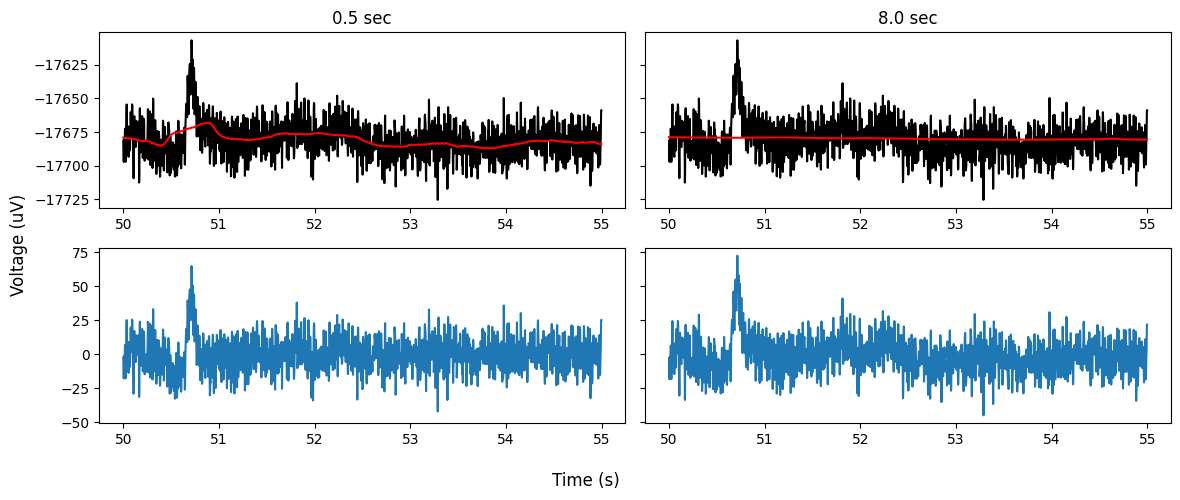

In [46]:
w = [125, 2000]
t_start_idx = 50*eeg.srate
t_end_idx = 55*eeg.srate
t_idxs = range(t_start_idx, t_end_idx)
fig, ax = plt.subplots(2,2,figsize=(12,5), sharey='row')
for i in range(2):
    eeg_ma = moving_average(eeg_data_full[:,0], w[i])
    eeg_resid = eeg_data_full[:,0].ravel() - eeg_ma
    ax[0,i].plot(eeg_t_full[t_idxs], eeg_data_full[t_idxs,0],color='k')
    ax[0,i].plot(eeg_t_full[t_idxs], eeg_ma[t_idxs], color='r')
    ax[0,i].set_title('{} sec'.format(2*w[i]/eeg.srate))
    ax[1,i].plot(eeg_t_full[t_idxs], eeg_resid[t_idxs])
fig.supxlabel('Time (s)')
fig.supylabel('Voltage (uV)')
fig.tight_layout()

The half-second window seems to follow the EEG a bit too closely, while the 8 second window is more even. Given all this, the 8 second window looks the best.

We can now create a function that takes the `EEG` object returns a version of it with the baseline subtracted.




In [47]:
# a function to remove baseline drift
def remove_baseline_drift(eeg, w=8):
    # eeg: an EEG object
    # w: window size in seconds
    # returns: an EEG object with baseline drift removed

    # convert window size to number of samples
    w = int((w/2) * eeg.srate)

    # create convolution kernel
    kernel = np.ones((1, 2*w+1)) / (2*w+1)

    # determine which channels are EEG
    eeg_chans = eeg.chans['type'] == 'EEG'

    # convolve kernel with EEG data using scipy.signal.convolve
    baseline = ss.convolve(eeg.data[eeg_chans,:], kernel, mode='same')

    # subtract baseline from EEG data
    eeg.data[eeg_chans,:] = eeg.data[eeg_chans,:] - baseline

    return eeg

eeg = remove_baseline_drift(eeg)

This function makes use of the `convolve` method found in the Scipy Signal package. The convolution operation is similar to the the moving average operation we created above. For the moving average, you can imagine that we are sliding a list of numbers (often called a *kernel*) that is as long as our window, and each has the value of $1/(2w+1)$, across the EEG time series. At each time point in the time series, we multiply the values in that time window with the corresponding values in the kernel, and add them together. This gives us the average surround each time point. With convolution, instead of having all the values in the kernel have the same value, they can take on different values. We will make use of this later.

[IMAGE OF CONVOLUTION]

Let's see how our baseline removal function performs.

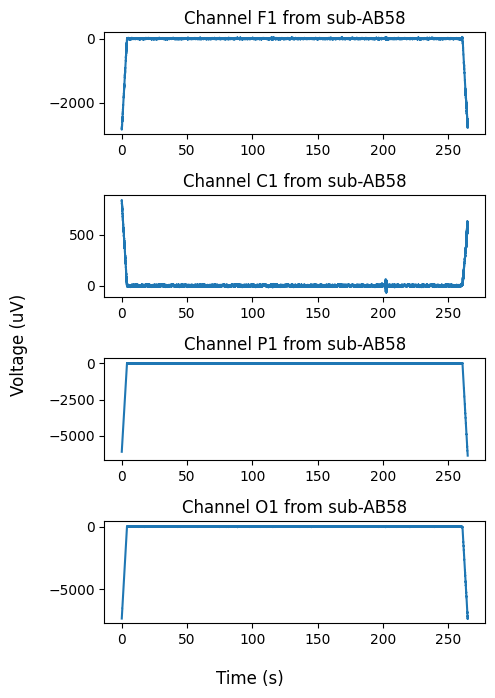

In [48]:
example_chans = ['F1', 'C1', 'P1', 'O1']

# get the eeg data for the drift channels
eeg_data_drift, eeg_t_drift, eeg_chan_drift = eeg.get_data(chans=example_chans)

# plot the eeg data for the drift channels
fig, ax = plt.subplots(4,1,figsize=(5,7))
for i in range(4):
    ax[i].plot(eeg_t_drift, eeg_data_drift[:,i,:])
    ax[i].set_title('Channel {} from {}'.format(eeg_chan_drift[i], subj))
fig.supxlabel('Time (s)')
fig.supylabel('Voltage (uV)')
fig.tight_layout()

Uh oh, it appears that we have edge effects. At the beginning and end of the time series there are distortions. This is because the scipy convolve function zero-pads the time series. To mitigate this, we can change the padding. Instead of using zeros, we will just take the signal value at the edges.

In [49]:
# a function to remove baseline drift
def remove_baseline_drift(eeg, w=8):
    # eeg: an EEG object
    # w: window size in seconds
    # returns: an EEG object with baseline drift removed

    # convert window size to number of samples
    w = int((w/2) * eeg.srate)

    # create convolution kernel
    kernel = np.ones((1, 2*w+1)) / (2*w+1)

    # determine which channels are EEG
    eeg_chans = eeg.chans['type'] == 'EEG'

    # pad data with edge values <-- HERE IS A CHANGE
    data_pad = np.pad(eeg.data[eeg_chans,:], ((0,0), (w,w)), 'edge')

    # convolve kernel with EEG data using scipy.signal.convolve
    # (mode='valid' to keep output the same size as the input after padding) <-- HERE IS A CHANGE
    baseline = ss.convolve(data_pad, kernel, mode='valid')

    # subtract baseline from EEG data
    eeg.data[eeg_chans,:] = eeg.data[eeg_chans,:] - baseline

    return eeg

To check if our fix worked, we will load a fresh version of the eeg object and try baseline removal again.

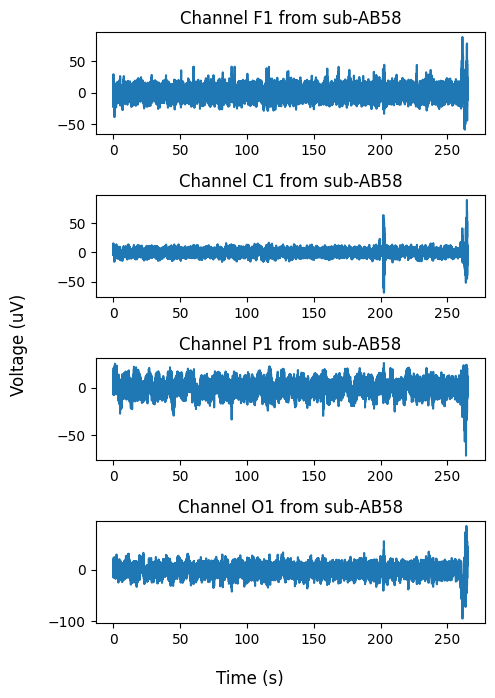

In [50]:
# create an EEG object
eeg = EEG(eeg_file, chan_file)

# remove baseline drift
eeg = remove_baseline_drift(eeg)

# plot EEG with baseline drift removed
drift_chans = ['F1', 'C1', 'P1', 'O1']

# get the eeg data for the drift channels
eeg_data_drift, eeg_t_drift, eeg_chan_drift = eeg.get_data(chans=example_chans)

# plot the eeg data for the drift channels
fig, ax = plt.subplots(4,1,figsize=(5,7))
for i in range(4):
    ax[i].plot(eeg_t_drift, eeg_data_drift[:,i,:])
    ax[i].set_title('Channel {} from {}'.format(eeg_chan_drift[i], subj))
fig.supxlabel('Time (s)')
fig.supylabel('Voltage (uV)')
fig.tight_layout()

Much better! We can now cross one source of noise off our list:
$$ EEG = Neural + EOG + ACPower + EMG \cancel{\ +\ Scalp} $$


#### Muscle artifacts
Your muscles are electromechanical devices that put out their own potentials, called *electromyographic* activity, abbreviated EMG. When a muscle is depolarized, it can produce a strong Na<sup>+</sup> and Ca<sup>2+</sup> action potential. Muscle contraction is driven by a barrage of these fast potentials, which can be picked up on electrodes many centimeters away. EMG will be most associated with mouth, forehead, and neck movements. Since EMG is associated with action potentials, its activity will be very fast relative to the slower activities detected in EEG. You can see EMG in the EEG signals shown above around 200 sec into the recording. Here is a closeup:

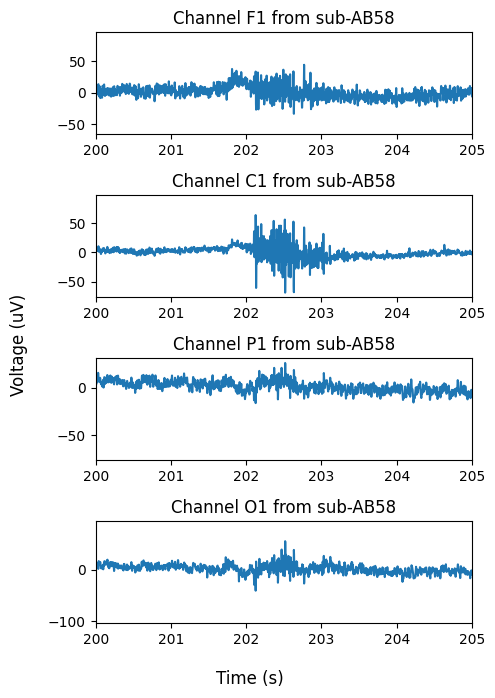

In [51]:
# plot the eeg data centered on a burst of EMG
fig, ax = plt.subplots(4,1,figsize=(5,7))
for i in range(4):
    ax[i].plot(eeg_t_drift, eeg_data_drift[:,i,:])
    ax[i].set_title('Channel {} from {}'.format(eeg_chan_drift[i], subj))
    ax[i].set_xlim([200, 205])
fig.supxlabel('Time (s)')
fig.supylabel('Voltage (uV)')
fig.tight_layout()

To remove EMG, you can use a *filter*. We already covered a type of filter, the moving averages we calculated were effectively filters that kept the slow baseline shift. The same concept can be applied to remove EMG, which is at a higher frequency than the neural sources of the EEG that we care about. To provide grater control over the frequencies we want to remove, we will now turn to the filter functions provided in the Scipy Signals package.

A filter is defined by its type, cutoff frequency, and order.

[PICTURE OF FILTER]

The two major types we will concern ourselves with are *low pass* and *high pass*. Low pass filters allow slow changes in the signal to be passed through, like the moving average above. High pass filters do the opposite, they block the slow portion of the signal and instead allow the faster components through.

When we talk about slow and fast parts of the signal, we formally define those by their *frequency*. We will discuss these in far greater detail in later lectures, but for now you can think of frequency as representing the time scale of the signal. Formally, frequency is measured in events per second, Hertz. If a signal fluctuates 10 times per second, then we say it has a frequency of 10 Hz. The *cutoff frequency* is the frequency that below which signals are allowed pass for a low pass filter, or which signals are above which are allowed to pass for high pass filters. EMG power tends to be present above 60 Hz. The range of frequencies that are relatively unattenuated by the filter are referred to as the *pass band*.

Filters are generally not perfect, they do not block all signals on one side of the cutof frequency, and allow all signals on the other side to pass unimpeded. To sharpen the cutoff transition, you can increase the order of the filter. However, this can introduce distortions into the signal, which usually inclines us to keep the order low.

Let's create a low pass filter using the Scipy Signals package to remove the EMG component from our EEG signal.

In [52]:
# create a low pass filter
b, a = ss.butter(4, 60, 'low', fs=eeg.srate) # create the filter coefficients

The function `butter` takes parameters that specify the properties of the filter, and returns the filter's *coefficients*, `b` and `a`. The `b` term is analogous to the kernel we used in when calculting the moving average, while the `a` term is a kernel applied to the previous values of the filter's output. If you generate a filter just with the `b` values (you can use `scipy.signal.firwin`), it is referred to as a finite impulse response (FIR). If your filter has `b` and `a` kernels, then it is an infinite impulse response (IIR) filter. IIR filters have dramatically improved performance over FIR. But how do we evaluate the performance of a filter? An easy way to visualize this is to pass signals with different frequencies through the filter, and measure how much they are attenuated. Signals in the filter's pass band should have little or no attenuation, while those outside it should be strongly surpressed.

The Scipy Signals package provides a function, `freqz` for doing this. Here is how to use it:

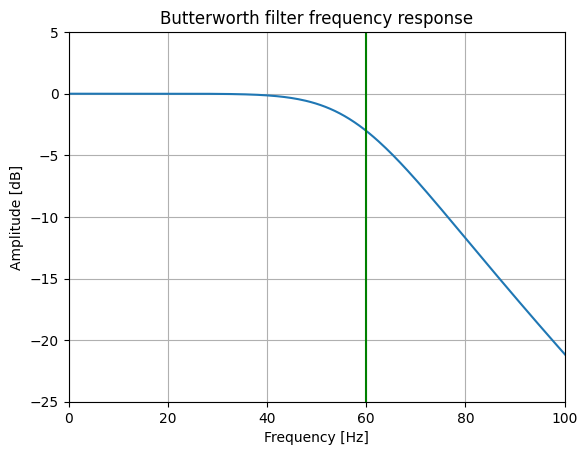

In [53]:
# compute the frequency response of the filter
w, h = ss.freqz(b, a, fs=eeg.srate)
freq_resp = 20*np.log10(abs(h)) # convert to dB

# plot the frequency response in Hz
plt.plot(w, freq_resp)
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.xlim(0, 100)
plt.ylim(-25, 5)
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(60, color='green') # cutoff frequency

The cutoff frequency is marked with a green vertical line. To see how the filter works, lets pass a type of periodic signal called a sine wave through it. As we increase the frequency of the sine wave above the cutoff, we should see a dramatic decrease in its amplitude.

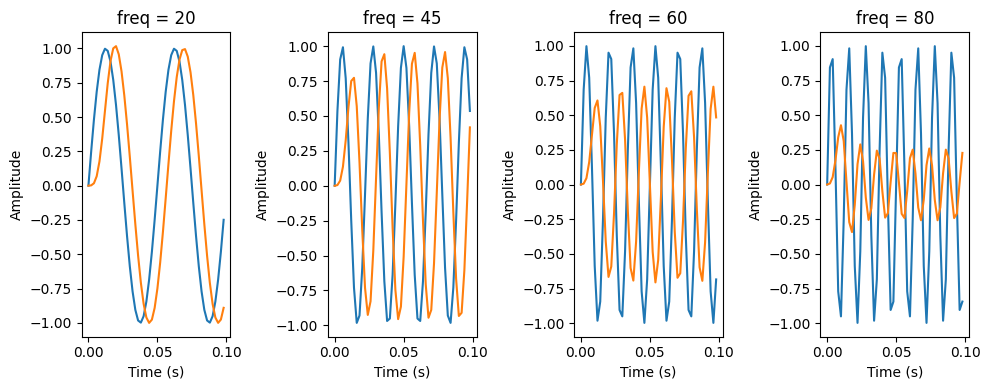

In [54]:
sin_freqs = [20, 45, 60, 80]
t_vals = np.arange(0, 0.1, 0.002)

# plot original sine wave and its filtered version
fig, ax = plt.subplots(1, 4, figsize=(10, 4))
for i, freq in enumerate(sin_freqs):
    sin_orig = np.sin(2*np.pi*freq*t_vals)
    sin_filt = ss.lfilter(b, a, sin_orig) # filter the signal
    ax[i].plot(t_vals, sin_orig)
    ax[i].plot(t_vals, sin_filt)
    ax[i].set_title('freq = {}'.format(freq))
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('Amplitude')
plt.tight_layout()

The blue lines are the original sine waves, while the orange is the filtered version. As we increase the frequency of the sine wave, the filter attenuates it more. At the cutoff frequency, 60 Hz, it is attenuated to approximately 70% of its original amplitude, which is known as the -3dB cutoff. You can also see that the filtered signal is shifted. This is known as *phase distortion* and varies as a function of the frequency. Using the output from the `freqz` function, we can visualize how this distortion varies systematically with frequency.

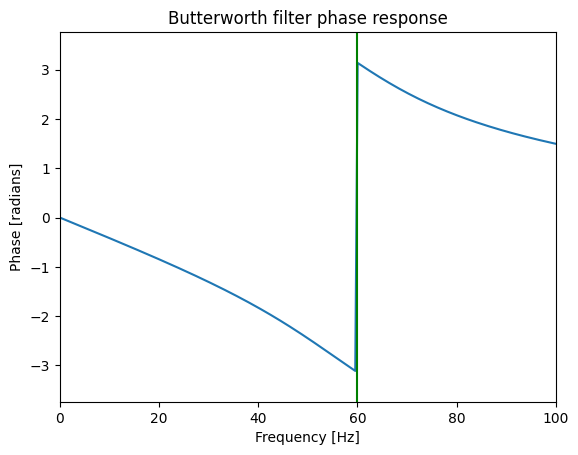

In [55]:
# plot the phase distortion of the butterworth filter
plt.plot(w, np.angle(h)) # h is an array of complex numbers, where the phase-shift is the angle of the complex number
plt.title('Butterworth filter phase response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [radians]')
plt.xlim(0, 100)
plt.margins(0, 0.1)
plt.axvline(60, color='green') # cutoff frequency

Edge effects are also present. At the start of the signal the shape of the filtered version is different from its shape later on, which appears to stabilize. This is due to the zero-padding done by the function `lsfilter`, similar to the issue we ran into with our moving average calculation. Also noteworthy is the lack of an edge effect at the end of the signal. This is because the filter kernels are slid across the signal from left to right, and the kernels are not symmetric. Unlike the moving average kernel, which was applied to data points before and after each sample in a time series, `b` and `a` are only applied to the samples before. This is also why we have a phase distortion, because the filter is applied in one direction, from past values to the present. When doing a BCI that has data streaming in real-time, this is the only option (you cannot know what brain activity will look like in the future). However, an offline BCI does not have this limitation. To slide the filter both direction, forwards, and then backwards, we can use `scipy.signals.filtfilt`.

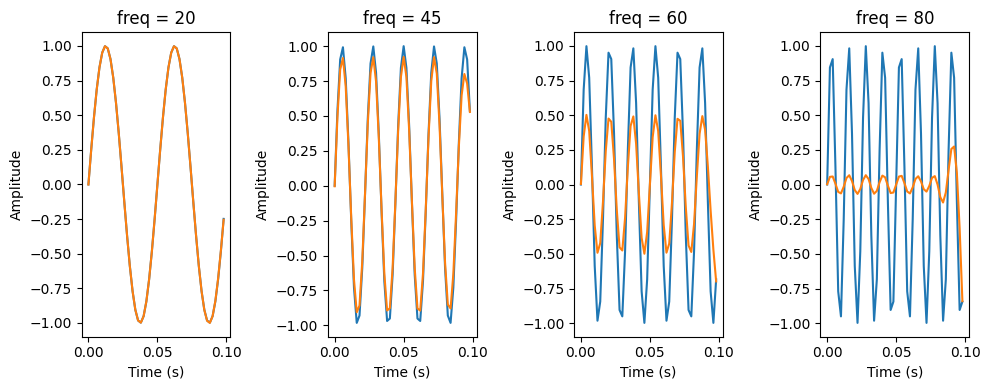

In [56]:
# plot original sine wave and its filtered version
fig, ax = plt.subplots(1, 4, figsize=(10, 4))
for i, freq in enumerate(sin_freqs):
    sin_orig = np.sin(2*np.pi*freq*t_vals)
    sin_filt = ss.filtfilt(b, a, sin_orig) # filter the signal forwards, and then backwards
    ax[i].plot(t_vals, sin_orig)
    ax[i].plot(t_vals, sin_filt)
    ax[i].set_title('freq = {}'.format(freq))
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('Amplitude')
plt.tight_layout()

Using `filtfilt` improved things! It virtually eliminated the phase distortion. Frequency selectivity is also better now, with frequencies outside the pass band showing greater reduction in amplitude. This is because the filter is applied twice. On the other hand, there is still an edge effect, but it is most prominent for frequencies outside the pass band.

Now that we are familiar with filters, we can apply them to removing EMG activity from the EEG signal. Let's create a function similar to our `remove_baseline_drift` to do that.

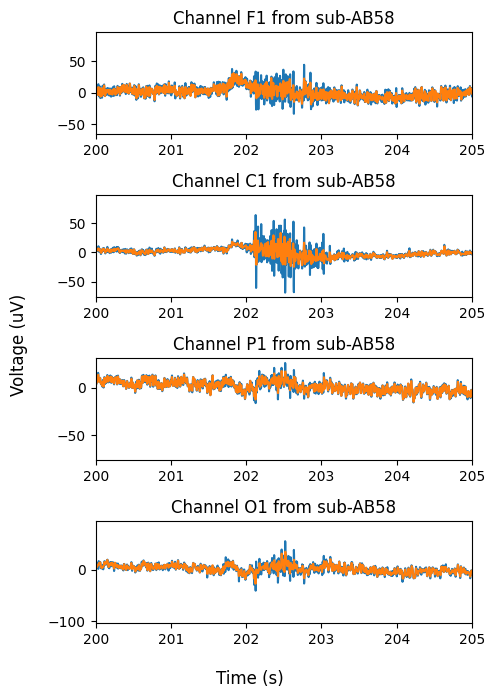

In [57]:
# function to remove EMG artifacts from EEG data
def remove_emg(eeg, cut_freq):
    # eeg: EEG data
    # cut_freq: cutoff frequency
    
    # create a bandpass filter
    b, a = ss.butter(4, cut_freq, 'low', fs=eeg.srate)
    
    # determine which channels are EEG
    eeg_chans = eeg.chans['type'] == 'EEG'

    # apply the filter to the data
    eeg.data[eeg_chans,:] = ss.filtfilt(b, a, eeg.data[eeg_chans,:], axis=1)
    
    # return the filtered data
    return eeg

# remove the emg from the data
eeg = remove_emg(eeg, 60)

# pull out the sample channels again, centered on the time period 
# with the EMG artifact
eeg_data_emg, eeg_t_emg, eeg_chan_emg = eeg.get_data(chans=example_chans, start_t=200, dur_t=5)

# overlay the EMG filtered over the original visualize the section of 
# data that previously had an EMG artifact
fig, ax = plt.subplots(4,1,figsize=(5,7))
for i in range(4):
    ax[i].plot(eeg_t_drift, eeg_data_drift[:,i,:])
    ax[i].plot(eeg_t_emg, eeg_data_emg[:,i,:])
    ax[i].set_title('Channel {} from {}'.format(eeg_chan_drift[i], subj))
    ax[i].set_xlim([200, 205])
fig.supxlabel('Time (s)')
fig.supylabel('Voltage (uV)')
fig.tight_layout()

The orange signal with the EMG filter applied shows less EMG activity than before, a good sign. Some still remains, but this will be hard to eliminate without distorting the EEG signal or removing frequencies that we care about.

$$ EEG = Neural + EOG + ACPower \cancel{\ + EMG \ }\cancel{\ +\ Scalp} $$


#### AC power line noise
Even with excellent referencing, AC power interference can still leak into recordings and must be dealt with. In the US this is at 60 Hz, while in Europe, where this recording comes from, it is at 50 Hz. What does this signal look like? In our recording, channel FCz exhibited prominent 50 Hz AC noise.

Text(0.5, 1.0, 'EEG data at FCz')

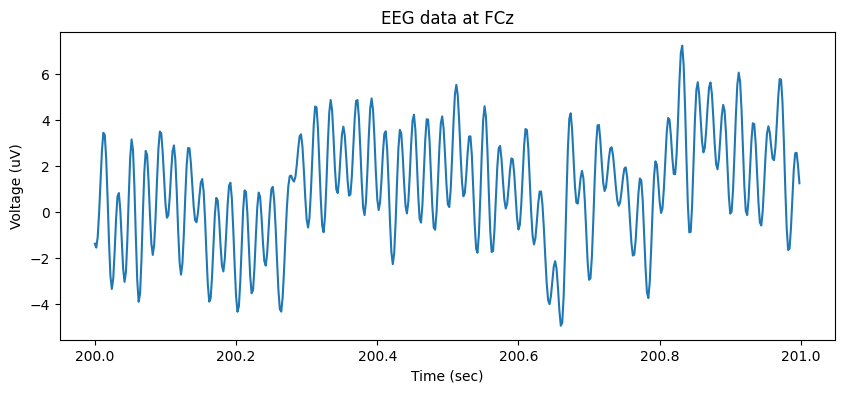

In [58]:
# Get an EEG epoch with a lot of AC noise
eeg_data_ac, eeg_t_ac, eeg_chan_ac = eeg.get_data(chans=['FCz'], start_t=200, dur_t=1)

# Plot the data
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(eeg_t_ac, eeg_data_ac.squeeze())
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('EEG data at FCz')

Notice that the EEG oscillates at a regular rate, and that this masks the underlying irregular EEG activity that presumably arises from neural sources. 

There are two filtering strategies we can use. The easiest way to eliminate it is to filter out any signals in the EEG that are at or above the frequency of the AC signal. For this would could apply the same filtering strategy we used for the EMG. But, keep in mind that if we set the cutoff frequency of the filter to the AC frequency, it will only attenuate it moderatly. To further surpress the AC signal, we would need to set the cutoff to a lower frequency, perhaps 30 Hz in the case of our 50 Hz AC noise. This runs the list of eliminating activity we care about, but let's try it anyway.

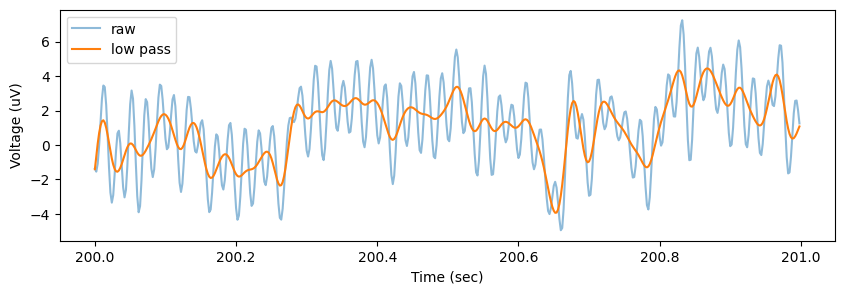

In [59]:
# load EEG signal with AC noise
eeg_data_ac, eeg_t_ac, eeg_chan_ac = eeg.get_data(chans=['FCz'], start_t=200, dur_t=1)

# create low pass filter
b_lp,a_lp = ss.butter(4, 30, 'low', fs=eeg.srate)

# apply filter
eeg_data_lp = ss.filtfilt(b_lp,a_lp,eeg_data_ac, axis=0)

# plot
plt.figure(figsize=(10,3))
plt.plot(eeg_t_ac, eeg_data_ac.squeeze(), label='raw', alpha=0.5)
plt.plot(eeg_t_ac, eeg_data_lp.squeeze(), label='low pass')
plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Voltage (uV)')
plt.show()

That certainly reduces the 50 Hz noise. However, the signal has now lost much of its sharpness because the cutoff for the low pass filter was set to 30 Hz. We are throwing out a lot of signal that may arise from neural sources.

The second filtering option is to use a *notch filter*. It suppresses frequencies centered on a specific value, such as 50 Hz, while allowing others to pass, whether they be higher or lower, to pass through unimpeded. This is useful for AC noise because its frequency is specific to just one value.

A notch filter is specified by two paramters. Its center frequency, $\omega_0$ (`w0` in the code below), sets frequency at which the maximum attenuation occurs. The depth of this attenuation and its spread to adjacent frequencies is determined by its Q (for quality) factor. A higher Q will decrease the attenuation at $\omega_0$ and its spread to adjacent frequencies. Thus, there is a tradeoff. The filter can strongly attenuate the frequency you want to reject, but at the cost of impacting other nearby frequencies. If you want to minimize that impact, you can lower Q, but at the cost of attenuating the center frequency less. Let's use the `iirnotch` function to create a notch filter at 50 Hz with a moderate Q.

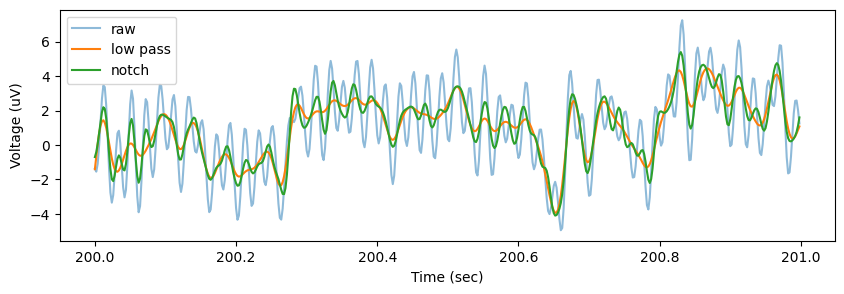

In [60]:
# create notch filter coeffients
b_nc, a_nc = ss.iirnotch(w0=50, Q=15, fs=eeg.srate)

# apply filter
eeg_data_nc = ss.filtfilt(b_nc,a_nc,eeg_data_ac, axis=0)

# plot
plt.figure(figsize=(10,3))
plt.plot(eeg_t_ac, eeg_data_ac.squeeze(),  label='raw', alpha=0.5)
plt.plot(eeg_t_ac, eeg_data_lp.squeeze(),  label='low pass')
plt.plot(eeg_t_ac, eeg_data_nc.squeeze(),  label='notch')
plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Voltage (uV)')
plt.show()

The notch filter allows higher frequencies to get through, whiile still attenuating the 50 Hz noise. While it is good to see a difference in filter performance by eye on the signals we want to process, a more systematic approach would be to characterize the frequency response properties of the filters.

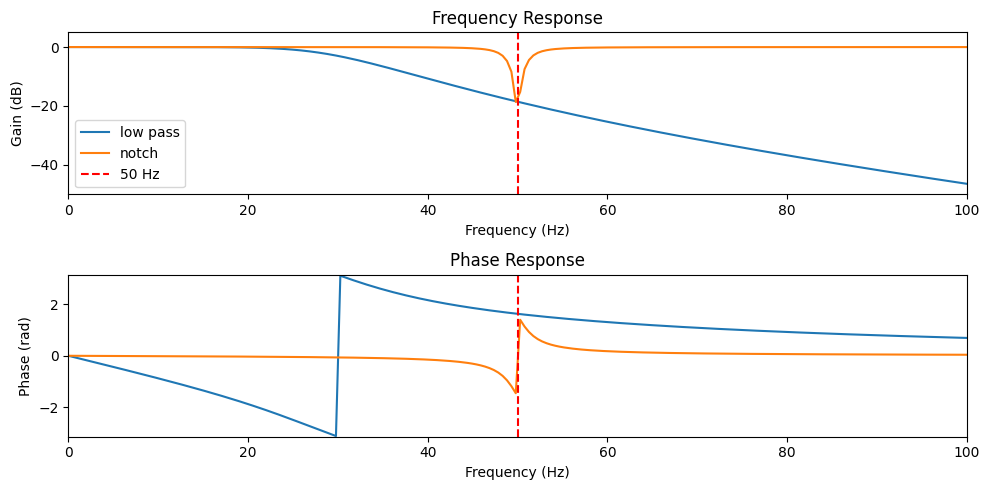

In [61]:
# calculate frequency responses of filters
w_lp, h_lp = ss.freqz(b_lp, a_lp, fs=eeg.srate)
w_nc, h_nc = ss.freqz(b_nc, a_nc, fs=eeg.srate)

# plot frequency response of filter
fig, ax = plt.subplots(2,1, figsize=(10,5))
ax[0].plot(w_lp, 20 * np.log10(abs(h_lp)), label='low pass')
ax[0].plot(w_nc, 20 * np.log10(abs(h_nc)), label='notch')
ax[0].axvline(50, color='red', linestyle='--', label='50 Hz')
ax[0].set_xlim(0,100)
ax[0].set_ylim(-50,5)
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Gain (dB)')
ax[0].set_title('Frequency Response')
ax[0].legend()

# plot the phase response of filter
ax[1].plot(w_lp, np.angle(h_lp))
ax[1].plot(w_nc, np.angle(h_nc))
ax[1].axvline(50, color='red', linestyle='--')
ax[1].set_xlim(0,100)
ax[1].set_ylim(-np.pi,np.pi)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Phase (rad)')
ax[1].set_title('Phase Response')
fig.tight_layout()


At the AC frequency, the attenuation from both the low pass and notch are equivalent. However, the drawback of the low pass is apparent due to it attenuating signals beyond the AC frequency. Given that, let's create a function for removing AC noise from the EEG using a notch filter.

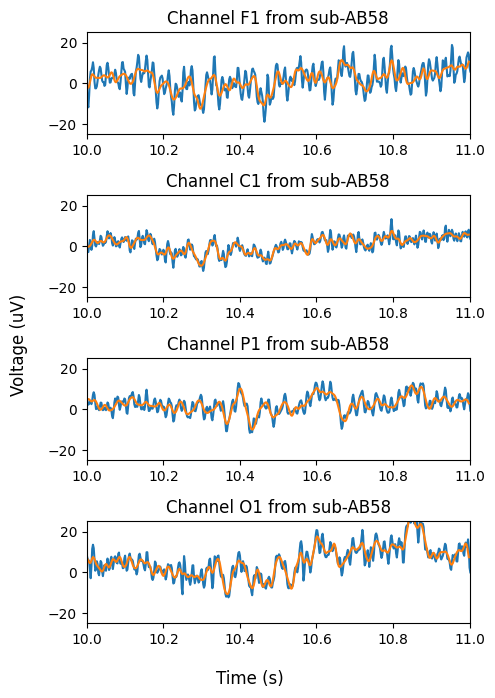

In [62]:
# function to remove AC noise from EEG data
def remove_ac(eeg, ac_freq=60): 
    # eeg: EEG data
    # ac_freq: frequency of the AC noise (default: 60 Hz because we're in the US)
    
    # create a bandpass filter
    b, a = ss.iirnotch(ac_freq, 15, fs=eeg.srate)
    
    # determine which channels are EEG
    eeg_chans = eeg.chans['type'] == 'EEG'

    # apply the filter to the data
    eeg.data[eeg_chans,:] = ss.filtfilt(b, a, eeg.data[eeg_chans,:], axis=1)
    
    # return the filtered data
    return eeg

# remove the emg from the data
eeg = remove_ac(eeg, 50)

# pull out the sample channels again, centered on the time period 
# with the EMG artifact
eeg_data_ac, eeg_t_ac, eeg_chan_ac = eeg.get_data(chans=example_chans, start_t=10, dur_t=1)

# overlay the AC filtered over the original signal
fig, ax = plt.subplots(4,1,figsize=(5,7))
for i in range(4):
    ax[i].plot(eeg_t_drift, eeg_data_drift[:,i,:])
    ax[i].plot(eeg_t_ac, eeg_data_ac[:,i,:])
    ax[i].set_title('Channel {} from {}'.format(eeg_chan_drift[i], subj))
    ax[i].set_xlim([10,11])
    ax[i].set_ylim([-25,25])
fig.supxlabel('Time (s)')
fig.supylabel('Voltage (uV)')
fig.tight_layout()

Our AC filter seems to work really well.

$$ EEG = Neural + EOG \cancel{\ + \ ACPower} \cancel{\ + EMG \ }\cancel{\ +\ Scalp} $$



#### Eye blinks and movement artifacts
Your eyeball is polarized, with large potential difference between the cornea and retina. This potential, referred to as the *electrooculogram* (https://pubmed.ncbi.nlm.nih.gov/31277871/) affects electrodes on the scalp, with those at frontal sites just above the eyes, such as F or Fp, picking it up most strongly. So long as the eye remains motionless, this just causes a constant offset in the voltage at an EEG electrode. But eyes move, a lot, especially when subjects are engaged in the kinds of activities we want to relate back to the brain. Your eyes constantly dart around, called saccading, between different spots in your field of view. When the eye moves or blinks, the voltages at your EEG sites change. Since each EEG electrode will pick this up differently, one cannot simply just rely on referencing to eliminate. The simplest way to deal with these is to measure the eye movements directly by placing electrodes adjacent to the subject's eyes, and then exclude periods when eye movements were present from subsequently analysis. More sophisticated approaches (e.g. independent component analysis) can isolate and remove the contribution of eye blinks to the EEG, allowing one to analyze periods where they occurred. These are beyond the purview of this course.

To detect eye blinks, investigators place recording electrodes near the subject's eyes. This gives a relatively pure measure of the EOG. Our recording has two channels for this, VEO and HEO. 

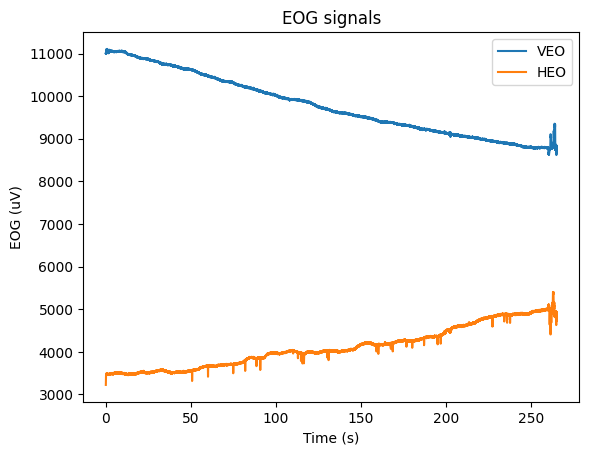

In [70]:
# get EOG signal
eog_data, eog_t, eog_chans = eeg.get_data(chans=['VEO', 'HEO'])

# plot EOG signal
plt.plot(eog_t, eog_data.squeeze(), label=eog_chans)
plt.xlabel('Time (s)')
plt.ylabel('EOG (uV)')
plt.title('EOG signals')
plt.legend()
plt.show()



Well, looks like we have drifting baselines in our EOG signals. If you look closely at the HEO trace, you can see little occasional ticks. These reflect eye blinks. They are not so apparent on the VEO trace. Remove the baseline from the HEO signal and zoom in on one of those eye blink events.

Text(0.5, 1.0, 'Eyeblink events')

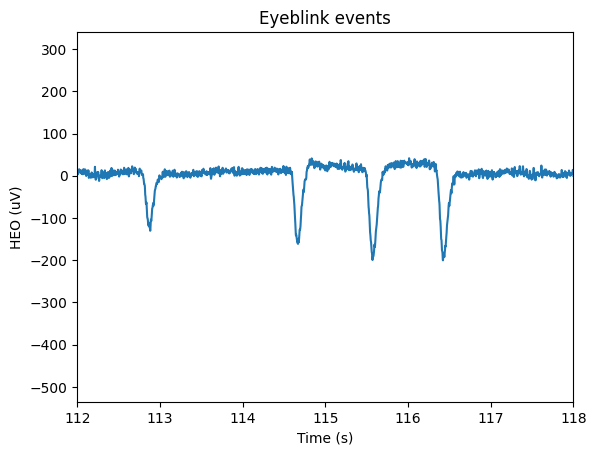

In [78]:
heo = eog_data[:, 1, 0].copy()

# moving average window
window = 1 # seconds
heo = heo-moving_average(heo, eeg.srate*window)

plt.plot(eog_t, heo)
plt.xlim((112, 118))
plt.xlabel('Time (s)')
plt.ylabel('HEO (uV)')
plt.title('Eyeblink events')

Each eyeblink is associated with a large voltage deflection (>150 uV) that, at least near the eye, dwarfs the EEG potentials we record from the scalp (~20 uV). To see how the EEG channels pick up the EOG, we will plot the same time period from our example EEG channels, whcih range from the front to the back of the scalp.

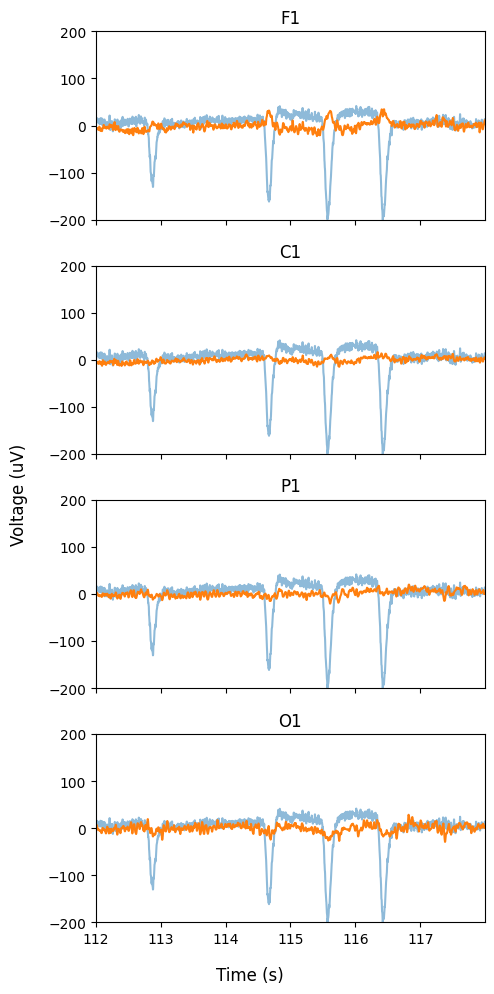

In [83]:
eeg_data, eeg_t, eeg_chans = eeg.get_data(chans=example_chans, start_t = 112, dur_t=6)

# Plot each eeg data channel in a separate axis with the heo signal underneath
fig, ax = plt.subplots(len(example_chans), 1, figsize=(5, 10), sharex=True)
for i, chan in enumerate(example_chans):
    ax[i].plot(eog_t, heo, alpha=0.5)
    ax[i].plot(eeg_t, eeg_data[:, i])
    ax[i].set_title(chan)
    ax[i].set_xlim([eeg_t[0], eeg_t[-1]])
    ax[i].set_ylim([-200, 200])
fig.supylabel('Voltage (uV)')
fig.supxlabel('Time (s)')
fig.tight_layout()


The EOG artifact is readily apparent on the frontal site, F1, which is closest to the eye. Its influence fades as one moves posteriorly (towards the back), but it can still have an impact. This can become especially problematic when we want to analyze brain activity during the presentation of visual stimuli. Often we blink or move our eyes invuluntarily during the presentation of visual stimuli, so we need a way to deal with this.

One approach is to discern a relationship between the EOG and EEG signals, and then use that relationship to predict how the EEG will be affected by EOG. Using this, one can subtract that predicted signal from the EEG, and hopefully completely excise the EOG's influence. This is doable, but is tricky to do well and we will not consider it further (but to see how, check out: https://pubmed.ncbi.nlm.nih.gov/6187540/).

The simplest approach is to detect the eye blink event from the EOG recording and block out that period from subsequent analysis. For this, we need to detect peaks in the EOG signal that exceed a threshold.



### A simple model of the EEG signal
We have just covered a variety of neural and non-neural sources for our EEG signal. This can be thought of as an equation:

$$ EEG = Neural_{spon} + Neural_{evoked} + EOG + EMG + Scalp + ACPower $$

For the rest of the lesson, we will go over how to eliminate or account for each these. In particular, we are interested in extracting $Neural_{evoked}$ component.

## Evoked response potentials
Whenever a stimulus is presented to a subject, it produces a chain of activation throughout the nervous system. Starting at the peripheral sensory receptors that detect the stimulus (such as the retina), a cascade of neural activation moves towards the cortex. Upon reaching the cortex, it is conveyed for further processing to determine the features of the stimulus and its relevance. This stimulus *evoked response* will have a stereotypical time course that, to some extent, is related to the properties of the stimulus and its meaning. Evoked responses were first demonstrated shortly after Berger discovered the EEG, and have remained a mainstay of undererstanding brain function.

Evoked responses can be characterized using the *event-related potential technique*. A subject with EEG electrodes is seated comfortably and performs a task that features the repeated presentation of stimuli. Sometimes the task is passive, in which case the subject simply attends to the stimuli but does not respond. Other times the task can be active and demands a response, such as a button press, that depends on the presentation of the stimulus or one of its features. Each stimulus presentation is referred to as *trial*. The periods between trials, the *inter-trial interval*, are usually several seconds long. This allows for the observable effects of the stimulus on brain state to fade and not contaminate the next stimulus presentation. 

Once the task is over, the researcher extracts the *epoch* of the EEG surrounding each time the stimulus was presented. They then average these with respect to time to generate 

[FIGURE OF EEG AVERAGING]

## Working with EEG data

### Loading EEG signals
DISCUSS .SET FILE
PLOT STACKED EEG LINES

### Time series data
SAMPLING A CONTINUOUS SIGNAL, SAMPLE RATE, RESOLUTION, MEAN, VARIANCE, AUTOCORRELATION

### Meta data
DISCUSS .SET, .TSV, .JSON
ROUTINES TO LOAD DATA

### Noise removal
BASELINE SUBTRACT, MOVING AVERAGE, CONVOLUTION, FILTERS, 

## Event-related potentials
### Evoking them
EXPERIMENTAL DESIGN, WINDOWING EEG SIGNALS BY EVENTS
### Time course
COMPONENTS, DEFINED BY LATENCY, MAGNITUDE, SIGN, DURATION
VARIABILITY ACROSS REPITITIONS WITH BOOTSTRAPPING
### Topography
EEG HAS GOOD TEMPORAL RESOLUTION, BUT POOR SPATIAL RESOLUTION. LOCALIZE ELECTRODES WHERE ERP COMPONENT IS STRONGEST

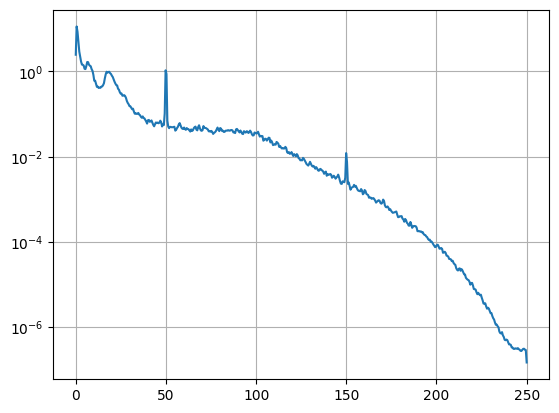

In [ ]:
root_dir = '/Users/drewheadley/Documents/Courses/DataScienceProgram/DecodingTheBrain/Datasets/ds003690'
subj = 'AB58'
eeg_file = op.join(root_dir, 'sub-{}/eeg/sub-{}_task-passive_run-1_eeg.set'.format(subj, subj))
evt_file = op.join(root_dir, 'sub-{}/eeg/sub-{}_task-passive_run-1_events.tsv'.format(subj, subj))
#'/Users/drewheadley/Documents/Courses/DataScienceProgram/DecodingTheBrain/Datasets/ds003690/sub-AB4/eeg/sub-AB4_task-passive_run-1_eeg.set'
#evt_file = '/Users/drewheadley/Documents/Courses/DataScienceProgram/DecodingTheBrain/Datasets/ds003690/sub-AB4/eeg/sub-AB4_task-passive_run-1_events.tsv'
eeg = sio.loadmat(eeg_file)
evt = pd.read_csv(evt_file, sep='\t')

samp_rate = eeg['srate'][0][0]
eeg_data = eeg['data']
nchan = eeg_data.shape[0]
nsamp = eeg_data.shape[1]
chan_info = eeg['chaninfo'][0][0][1]
ref_elec = eeg['ref']

evt_times = evt['sample'][evt['trial_type']=='cue'].values
# create a matrix of indices for the 200 ms window around each event
evt_inds = np.tile(evt_times, (int(samp_rate), 1)).T + np.arange(-int(samp_rate/2), int(samp_rate/2))

ind = 40
sel_eeg = eeg_data[ind,:]
f, Pxx_den = ss.welch(sel_eeg, samp_rate, nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.grid()

In [ ]:
chan_info

array(['Fp1 69 -2.854012 12.903291 -1.520481 ',
       'Fpz 69 0.583218 13.494058 -1.592608  ',
       'Fp2 69 3.935400 12.477923 -2.102277  ',
       'AF3 69 -3.023524 12.428141 1.361401  ',
       'AF4 69 4.304501 11.727693 0.427403   ',
       'F7 69 -6.639328 8.170529 -1.526560   ',
       'F5 69 -5.876012 9.542894 0.800148    ',
       'F3 69 -4.229360 10.265764 2.418731   ',
       'F1 69 -1.882614 11.018632 4.587177   ',
       'Fz 69 0.596303 10.217070 4.293318    ',
       'F2 69 3.996278 10.694478 3.944555    ',
       'F4 69 5.631967 9.848669 2.084015     ',
       'F6 69 6.969560 8.879675 -0.060155    ',
       'F8 69 7.878357 7.523402 -2.148623    ',
       'FT7 69 -7.918441 5.400486 -0.685157  ',
       'FC5 69 -6.848348 6.444450 1.872787   ',
       'FC3 69 -5.007377 6.820720 4.378383   ',
       'FC1 69 -2.332303 7.275606 6.020996   ',
       'FCz 69 0.892164 7.275017 6.676030    ',
       'FC2 69 3.868832 7.218509 5.929260    ',
       'FC4 69 6.393416 6.765655 4.16185

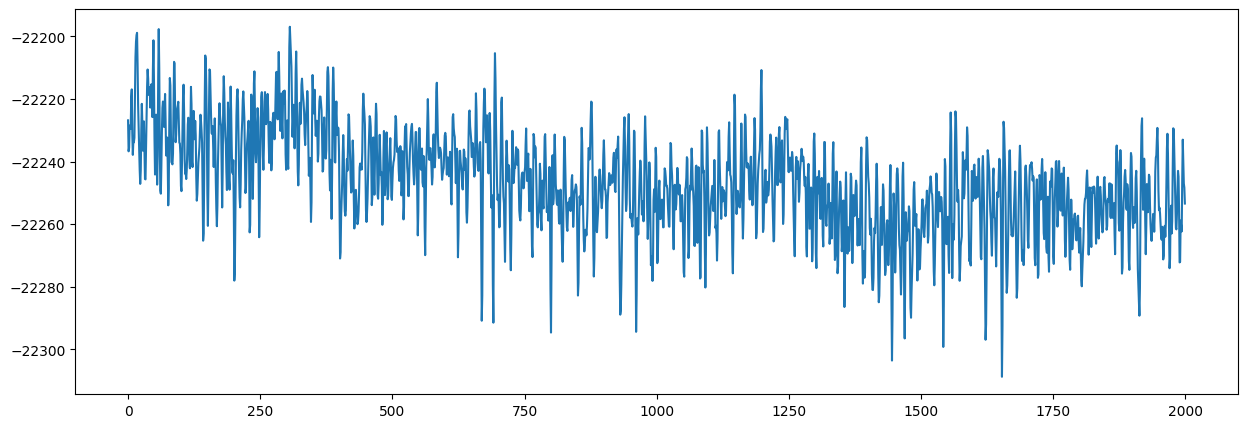

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(eeg_data[1,10000:12000])

Text(0.5, 1.0, 'CP6 69 7.889221 -0.063045 4.064806   ')

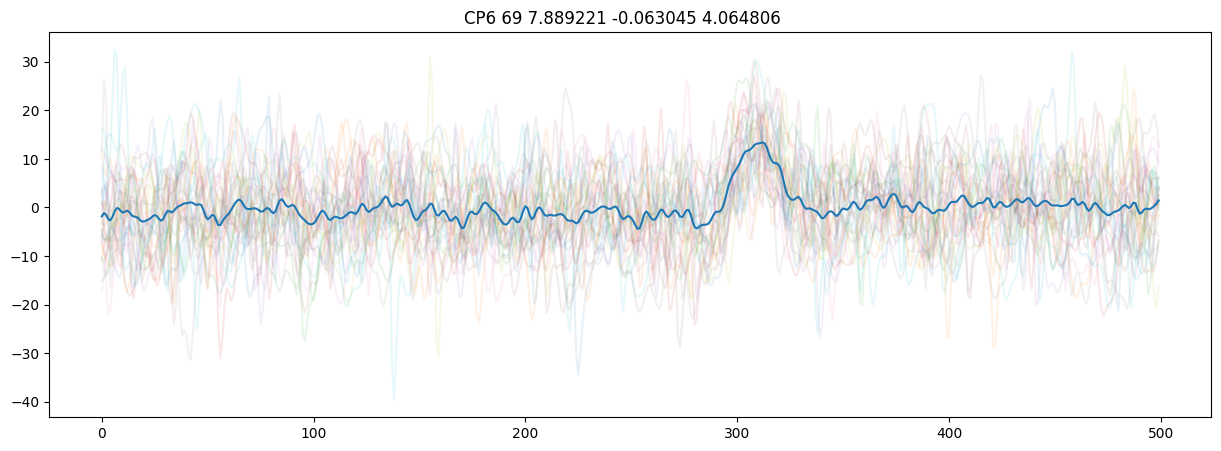

In [ ]:
ind = 40
sel_eeg = eeg_data[ind,:]
# apply 60 hz notch filter
b,a = ss.butter(2, 100, btype='low', fs=samp_rate)

#freq, h = ss.freqz(b,a,fs=samp_rate)
#plt.plot(freq, np.abs(h))
'''seg_eeg = sel_eeg[evt_inds]
plt.plot(seg_eeg[0,:], color='k')
sel_eeg = ss.filtfilt(b,a,sel_eeg)
seg_eeg = sel_eeg[evt_inds]
plt.plot(seg_eeg[0,:], color='r')'''

sel_eeg = ss.filtfilt(b,a,sel_eeg)
seg_eeg = sel_eeg[evt_inds]
plt.plot(seg_eeg.T-np.mean(seg_eeg,axis=1), alpha=0.1)
plt.plot(np.mean(seg_eeg.T-np.mean(seg_eeg,axis=1),axis=1))
plt.title(chan_info[ind])

In [ ]:
'''seg_eeg = sel_eeg[evt_inds]
plt.plot(seg_eeg[0,:], color='k')
sel_eeg = ss.filtfilt(b,a,sel_eeg)
seg_eeg = sel_eeg[evt_inds]
plt.plot(seg_eeg[0,:], color='r')'''

sel_eeg = ss.filtfilt(b,a,sel_eeg)
seg_eeg = sel_eeg[evt_inds]
plt.plot(seg_eeg.T-np.mean(seg_eeg,axis=1), alpha=0.1)
plt.plot(np.mean(seg_eeg.T-np.mean(seg_eeg,axis=1),axis=1))
plt.title(chan_info[ind])

In [ ]:
# power specturm of sel_eeg
